In [1]:
import pandas as pd
import unicodedata
import re
import jellyfish as jf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime

In [2]:
pd.set_option('display.max_columns', None)

# Dataset

In [3]:
df = pd.read_csv("data_examen.csv")

In [4]:
df.shape

(600000, 9)

In [5]:
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_class
0,2012-11-11 13:45:00.00000029,12.5,2012-11-11 13:45:00 UTC,-73.956322,40.813427,-73.959143,40.783220,1,low_fare
1,2010-01-26 00:13:00.00000050,11.3,2010-01-26 00:13:00 UTC,-73.982577,40.746018,-73.980713,40.780807,1,low_fare
2,2014-10-07 19:24:00.000000235,19.5,2014-10-07 19:24:00 UTC,-73.972000,40.759470,-74.006190,40.708460,2,low_fare
3,2012-10-20 13:48:40.0000002,10.5,2012-10-20 13:48:40 UTC,-74.002701,40.728209,-74.013599,40.710990,1,low_fare
4,2014-04-29 20:27:00.000000186,7.0,2014-04-29 20:27:00 UTC,-73.982517,40.770782,-73.979932,40.754880,1,low_fare
...,...,...,...,...,...,...,...,...,...
599995,2010-07-20 09:21:00.00000052,14.5,2010-07-20 09:21:00 UTC,-73.979120,40.746182,-74.004187,40.705937,1,low_fare
599996,2013-02-20 15:16:27.0000004,3.5,2013-02-20 15:16:27 UTC,-73.955352,40.804620,-73.955352,40.804620,1,low_fare
599997,2010-10-07 22:32:00.000000223,7.3,2010-10-07 22:32:00 UTC,0.000000,0.000000,0.000000,0.000000,2,low_fare
599998,2010-09-13 13:28:00.000000138,4.1,2010-09-13 13:28:00 UTC,-73.973527,40.784913,-74.001877,40.740657,6,low_fare


In [6]:
df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
fare_class            object
dtype: object

In [7]:
tot_registos, tot_variables = df.shape

# Calidad de datos

## Etiquetado de variables

In [8]:
v_feats=["fare_class"]
c_feats=['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude',
         'dropoff_latitude','passenger_count']
d_feats = ['pickup_datetime']
id_feats = ['key']

c_feats_new=["c_"+x for x in c_feats]
v_feats_new=["v_"+x for x in v_feats]
d_feats_new=["d_"+x for x in d_feats]
id_feats_new=["id_"+x for x in id_feats]

df.rename(columns=dict(zip(c_feats,c_feats_new)),inplace=True)
df.rename(columns=dict(zip(v_feats,v_feats_new)),inplace=True)
df.rename(columns=dict(zip(d_feats,d_feats_new)),inplace=True)
df.rename(columns=dict(zip(id_feats,id_feats_new)),inplace=True)

In [9]:
df.columns

Index(['id_key', 'c_fare_amount', 'd_pickup_datetime', 'c_pickup_longitude',
       'c_pickup_latitude', 'c_dropoff_longitude', 'c_dropoff_latitude',
       'c_passenger_count', 'v_fare_class'],
      dtype='object')

## Duplicidad

primero vamos a revisar si nuestro identificador de unidad muestral nos sirve

In [10]:
df['id_key'].describe()

count                           600000
unique                          600000
top       2012-11-11 13:45:00.00000029
freq                                 1
Name: id_key, dtype: object

comparamos si id_key y  d_pickup_datetime son iguales 

In [11]:
np.sum(pd.to_datetime(df['id_key'], format="%Y-%m-%d %H:%M:%S.%f")== pd.to_datetime(df['d_pickup_datetime'], format = "%Y-%m-%d %H:%M:%S %Z"))

0

revisando la columna id_key observamos que esta tiene fracciones de segundo y d_pickup_datetime solo llega hasta segundos, por eso python no las identifica como iguales, vamos a truncar las columnas hasta segundo y volvemos a comparar

In [12]:
np.sum(pd.to_datetime(df['id_key'], format="%Y-%m-%d %H:%M:%S.%f").dt.strftime("%Y-%m-%d %H:%M:%S") == pd.to_datetime(df['d_pickup_datetime'], format = "%Y-%m-%d %H:%M:%S %Z").dt.strftime("%Y-%m-%d %H:%M:%S"))

600000

el resultado es que las dos son iguales(truncando en segundos), por lo que vamos a sustituir d_pickup_datetime por el valor de  id_key (ya que tiene pas presicion por las fracciones de segund), y vamos a eliminar id_key

In [13]:
df['d_pickup_datetime'] = pd.to_datetime(df['id_key'], format="%Y-%m-%d %H:%M:%S.%f")
df.drop('id_key', axis=1, inplace=True)

In [14]:
df

,c_fare_amount,d_pickup_datetime,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,v_fare_class
0,12.5,2012-11-11 13:45:00.000000290,-73.956322,40.813427,-73.959143,40.783220,1,low_fare
1,11.3,2010-01-26 00:13:00.000000500,-73.982577,40.746018,-73.980713,40.780807,1,low_fare
2,19.5,2014-10-07 19:24:00.000000235,-73.972000,40.759470,-74.006190,40.708460,2,low_fare
3,10.5,2012-10-20 13:48:40.000000200,-74.002701,40.728209,-74.013599,40.710990,1,low_fare
4,7.0,2014-04-29 20:27:00.000000186,-73.982517,40.770782,-73.979932,40.754880,1,low_fare
...,...,...,...,...,...,...,...,...
599995,14.5,2010-07-20 09:21:00.000000520,-73.979120,40.746182,-74.004187,40.705937,1,low_fare
599996,3.5,2013-02-20 15:16:27.000000400,-73.955352,40.804620,-73.955352,40.804620,1,low_fare
599997,7.3,2010-10-07 22:32:00.000000223,0.000000,0.000000,0.000000,0.000000,2,low_fare
599998,4.1,2010-09-13 13:28:00.000000138,-73.973527,40.784913,-74.001877,40.740657,6,low_fare


checamos si a nivel tabla hay duplicados 

In [15]:
df.duplicated().sum()

0

definimos nuestra unidad muestral como c_fare_amount,d_pickup_datetime,c_pickup_longitude ya que la hora exacta y lugar de recogida exacto son eventos unicos, revisamos si hay duplicados considerando estas variables 

In [16]:
df.duplicated(subset = ['c_fare_amount','d_pickup_datetime','c_pickup_longitude']).sum()

0

no encontramos datos duplicados

## completitud 

In [17]:
df.isnull().sum(axis=0)

c_fare_amount          0
d_pickup_datetime      0
c_pickup_longitude     0
c_pickup_latitude      0
c_dropoff_longitude    7
c_dropoff_latitude     7
c_passenger_count      0
v_fare_class           0
dtype: int64

In [18]:
df[df.isnull().any(axis = 1)]

,c_fare_amount,d_pickup_datetime,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,v_fare_class
54649,10.20,2013-11-04 20:59:15.000000100,-73.998460,40.745406,NaN,NaN,0,low_fare
68599,14.76,2011-09-25 23:01:12.000000500,-73.985374,40.768518,NaN,NaN,0,low_fare
186380,12.50,2012-12-11 12:57:00.000000130,-73.992760,40.743098,NaN,NaN,0,low_fare
264084,40.00,2011-06-20 11:34:44.000000100,-73.862900,40.768900,NaN,NaN,0,high_fare
374983,11.80,2011-09-08 09:12:52.000000100,-73.987041,40.751542,NaN,NaN,0,low_fare
378056,7.80,2012-12-11 12:34:20.000000600,0.000000,0.000000,NaN,NaN,0,low_fare
458033,7.20,2013-11-04 20:07:59.000000600,-73.977048,40.787565,NaN,NaN,0,low_fare


tenemos 7 casos donde la ubicacion destino no fue registrada, por el momento dejamos así los datos, más adelante imputaremos despues de checar atipicos


## Presición/Orden

### revisión de variables unitarias 

In [19]:
def unitarias(df2,col):
    result=pd.DataFrame(df2[col].value_counts(1))
    if result.shape[0]>0:
        if (result.iloc[0,0]>.91) :
            print(f"{col} -- VARIABLE UNITARIA")

Revisamos para nuestra unica variable categorica

In [20]:
unitarias(df,'v_fare_class')

no la detecta como variable unitaria 

### variables categoricas

In [21]:
df['v_fare_class'].value_counts()

v_fare_class
low_fare     543539
high_fare     56461
Name: count, dtype: int64

solo hay 2 categorias, y eso es correcto

### variables numericas

**c_fare_amount**

In [22]:
df['c_fare_amount'].value_counts()

c_fare_amount
6.50      29082
4.50      24640
8.50      22536
5.30      17652
5.70      17554
          ...  
66.83         1
69.33         1
74.90         1
38.70         1
156.99        1
Name: count, Length: 1785, dtype: int64

In [23]:
df['c_fare_amount'].dtype

dtype('float64')

**c_pickup_longitude**

In [24]:
df['c_pickup_longitude'].value_counts()

c_pickup_longitude
 0.000000     11365
-73.137393      199
-73.982100       54
-73.981500       52
-73.982095       51
              ...  
-73.911205        1
-73.926386        1
-74.011292        1
-73.941640        1
-73.924725        1
Name: count, Length: 99891, dtype: int64

In [25]:
df['c_pickup_longitude'].dtype

dtype('float64')

**c_pickup_latitude**

In [26]:
df['c_pickup_latitude'].value_counts()

c_pickup_latitude
0.000000     11333
41.366138      199
40.774057       49
40.774037       48
40.774102       42
             ...  
40.744616        1
40.695135        1
40.814747        1
40.798321        1
40.804620        1
Name: count, Length: 126242, dtype: int64

In [27]:
df['c_pickup_latitude'].dtype

dtype('float64')

**c_dropoff_longitude**

In [28]:
df['c_dropoff_longitude'].value_counts()

c_dropoff_longitude
 0.000000     11363
-73.137393      148
-73.982297       50
-73.982300       45
-73.984700       45
              ...  
-76.462462        1
-74.013588        1
-73.923367        1
-74.012744        1
-73.933638        1
Name: count, Length: 114894, dtype: int64

In [29]:
df['c_dropoff_longitude'].dtype

dtype('float64')

**c_dropoff_latitude**

In [30]:
df['c_dropoff_latitude'].value_counts()

c_dropoff_latitude
0.000000     11333
41.366138      148
40.750062       39
40.750392       39
40.750107       38
             ...  
40.705151        1
40.762894        1
40.676660        1
40.708993        1
40.780975        1
Name: count, Length: 144434, dtype: int64

In [31]:
df['c_dropoff_latitude'].dtype

dtype('float64')

**c_passenger_count** 

In [32]:
df['c_passenger_count'].value_counts()

c_passenger_count
1      415060
2       88628
5       42220
3       26323
4       12922
6       12716
0        2130
208         1
Name: count, dtype: int64

In [33]:
df['c_passenger_count'].dtype

dtype('int64')

todas parecen correctas 

### variable de fecha

In [34]:
df['d_pickup_datetime'].value_counts()

d_pickup_datetime
2010-03-15 18:24:00.000000800    2
2011-03-17 23:23:00.000000700    2
2014-09-03 10:35:00.000000110    2
2009-11-14 20:43:33.000000100    2
2011-10-26 07:22:00.000000300    2
                                ..
2013-03-16 03:55:45.000000100    1
2010-05-06 06:51:32.000000400    1
2009-01-25 05:33:38.000000100    1
2010-12-23 01:59:00.000000650    1
2014-09-03 20:35:37.000000400    1
Name: count, Length: 599935, dtype: int64

In [35]:
df['d_pickup_datetime'].dtype

dtype('<M8[ns]')

## consistencia

### variables numericas

**c_fare_amount**

In [36]:
df['c_fare_amount'].describe()

count    600000.000000
mean         11.369602
std           9.882086
min         -44.900000
25%           6.000000
50%           8.500000
75%          12.500000
max         495.000000
Name: c_fare_amount, dtype: float64

vemos datos negativos, revisemos cuantos son

In [37]:
df[df['c_fare_amount'] < 0]

,c_fare_amount,d_pickup_datetime,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,v_fare_class
41704,-2.50,2015-05-31 10:23:50.000000300,-73.982162,40.773621,-73.982094,40.773811,2,low_fare
83429,-2.50,2015-01-15 17:33:24.000000100,-73.982567,40.739799,-73.982567,40.739799,2,low_fare
85442,-3.00,2013-08-30 08:57:10.000000200,-73.995062,40.740755,-73.995885,40.741357,4,low_fare
115048,-5.00,2015-03-09 10:29:46.000000400,-73.990974,40.755985,-73.980820,40.759869,1,low_fare
121743,-6.50,2015-01-01 04:35:09.000000400,-73.993660,40.746986,-73.980347,40.742802,1,low_fare
131862,-5.00,2015-06-26 01:13:18.000000200,-73.979797,40.743240,-73.981216,40.737240,6,low_fare
159068,-4.50,2015-02-13 00:36:36.000000200,-74.006142,40.740425,-74.009827,40.738804,1,low_fare
185707,-2.90,2010-02-10 12:33:10.000000400,-73.970775,40.783425,-73.973443,40.779775,1,low_fare
210493,-3.00,2015-06-07 02:54:14.000000400,-73.913246,40.766212,-73.914963,40.764065,5,low_fare
289810,-2.50,2010-03-09 18:18:10.000000600,-73.885183,40.772840,-73.885178,40.772838,1,low_fare


la target contiene valores negativos, esto no es algo consistente, tenemos 3 opciones para solucionarlo 
1. Convertirlo a Nulo para despues imputar
2. Pasar el valor a positivo
3. Eliminar los registros

Si fuera el caso de alguna feature se podría aplicar el 1 sin problema, al ser la target es mejor no alterarla y dejarla tal y como esta, por lo mismo no aplicaria el segundo caso (a menos que estuvieramos 100% seguros que fue solo un error de signo). Al ser pocos registros es mejor eliminnarlos

In [38]:
df = df.loc[df['c_fare_amount'] >= 0]

**c_pickup_longitude y c_pickup_latitude**

In [39]:
df['c_pickup_longitude'].describe()

count    599975.000000
mean        -72.515167
std          12.877422
min       -3377.680935
25%         -73.992057
50%         -73.981785
75%         -73.967090
max        2522.271325
Name: c_pickup_longitude, dtype: float64

la longitud solo tiene valores aceptables de -180 a 180 y se pueden ver casos que no estan en este rango

In [40]:
df[(df['c_pickup_longitude'] < -180 )| (df['c_pickup_longitude'] > 180 )]

,c_fare_amount,d_pickup_datetime,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,v_fare_class
114220,17.3,2012-03-22 21:40:00.000000188,2522.271325,2621.628430,-1718.117653,-2864.471003,1,low_fare
122394,6.5,2012-07-21 15:23:00.000000930,-736.416665,40.752285,-73.992565,40.742687,1,low_fare
206343,11.5,2013-05-23 15:23:00.000000700,-735.888333,40.760863,-73.989835,40.738443,5,low_fare
366493,5.3,2011-10-28 13:53:00.000000178,-3377.680935,-113.019497,-554.918693,314.794180,1,low_fare
380235,16.9,2011-10-28 10:53:00.000000800,-1452.988333,40.776000,-73.989487,40.740667,2,low_fare
403077,6.1,2012-06-03 23:21:00.000000770,-740.000000,40.747620,0.000000,0.000000,6,low_fare
425880,4.1,2012-03-11 01:56:00.000000100,-2986.242495,-880.627428,-3383.296608,-2559.748913,1,low_fare
444375,9.7,2011-11-21 21:36:00.000000810,2140.601160,1703.092772,-1251.195890,-1189.615440,1,low_fare


estos casos los vamos a dejar en null para despues imputar

In [41]:
df.loc[(df['c_pickup_longitude'] < -180 )| (df['c_pickup_longitude'] > 180 ),'c_pickup_longitude'] = np.nan

In [42]:
df['c_pickup_latitude'].describe()

count    599975.000000
mean         39.923526
std           8.465064
min       -3116.285383
25%          40.734945
50%          40.752730
75%          40.767213
max        2621.628430
Name: c_pickup_latitude, dtype: float64

caso similar pasa para la latitud, solo que esta solo acepta valores de -90 a 90

In [43]:
df.loc[(df['c_pickup_latitude'] < -90 )| (df['c_pickup_latitude'] > 90 )] 

,c_fare_amount,d_pickup_datetime,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,v_fare_class
64516,5.3,2012-05-24 22:44:00.000000880,-73.989188,91.266667,-73.982362,40.763105,1,low_fare
114220,17.3,2012-03-22 21:40:00.000000188,NaN,2621.628430,-1718.117653,-2864.471003,1,low_fare
133946,6.9,2012-03-05 20:58:00.000000900,-73.994268,404.966667,-73.973857,40.755457,1,low_fare
220755,25.3,2012-08-03 07:43:00.000000176,0.000000,-3116.285383,-73.953600,40.787998,1,high_fare
366493,5.3,2011-10-28 13:53:00.000000178,NaN,-113.019497,-554.918693,314.794180,1,low_fare
425880,4.1,2012-03-11 01:56:00.000000100,NaN,-880.627428,-3383.296608,-2559.748913,1,low_fare
431544,5.7,2012-04-12 07:31:00.000000270,-73.957087,424.083332,-73.968312,40.765117,1,low_fare
444375,9.7,2011-11-21 21:36:00.000000810,NaN,1703.092772,-1251.195890,-1189.615440,1,low_fare
550298,8.5,2012-03-16 08:13:00.000000272,-73.994277,405.133332,-73.956763,40.783737,1,low_fare


de igual forma convertimos a null para despues imputar

In [44]:
df.loc[(df['c_pickup_latitude'] < -90 )| (df['c_pickup_latitude'] > 90 ),'c_pickup_latitude']  = np.nan

**c_dropoff_longitude y	c_dropoff_latitude**

In [45]:
df['c_dropoff_longitude'].describe()

count    599968.000000
mean        -72.524262
std          11.833467
min       -3383.296608
25%         -73.991383
50%         -73.980102
75%         -73.963607
max          40.851027
Name: c_dropoff_longitude, dtype: float64

In [46]:
df[(df['c_dropoff_longitude'] < -180 )| (df['c_dropoff_longitude'] > 180 )]

,c_fare_amount,d_pickup_datetime,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,v_fare_class
33273,5.7,2012-02-09 17:42:00.000000178,-74.006390,40.739552,-740.066667,40.724792,1,low_fare
100812,6.1,2012-06-19 07:41:00.000000190,-73.982467,40.771612,-736.416665,40.764310,1,low_fare
108096,6.9,2012-01-28 16:51:00.000000880,-73.983142,40.741987,-736.500000,40.755255,1,low_fare
114220,17.3,2012-03-22 21:40:00.000000188,NaN,NaN,-1718.117653,-2864.471003,1,low_fare
295526,8.1,2012-02-18 00:22:00.000000100,-73.991215,40.750727,-740.000000,40.726617,1,low_fare
366493,5.3,2011-10-28 13:53:00.000000178,NaN,NaN,-554.918693,314.794180,1,low_fare
425880,4.1,2012-03-11 01:56:00.000000100,NaN,NaN,-3383.296608,-2559.748913,1,low_fare
434751,17.7,2012-05-24 09:00:00.000000101,-73.997572,40.720945,-1329.621332,40.773717,1,low_fare
444375,9.7,2011-11-21 21:36:00.000000810,NaN,NaN,-1251.195890,-1189.615440,1,low_fare
573884,4.9,2012-03-16 22:02:00.000000257,-73.992605,40.726815,-472.266667,40.733332,1,low_fare


convertimos a null

In [47]:
df.loc[(df['c_dropoff_longitude'] < -180 )| (df['c_dropoff_longitude'] > 180 ),'c_dropoff_longitude'] = np.nan

In [48]:
df.loc[(df['c_dropoff_latitude'] < -90 )| (df['c_dropoff_latitude'] > 90 )] 

,c_fare_amount,d_pickup_datetime,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,v_fare_class
114220,17.3,2012-03-22 21:40:00.000000188,NaN,NaN,NaN,-2864.471003,1,low_fare
117668,30.5,2012-05-02 14:20:00.000000131,-73.870875,40.773792,-73.977790,404.716667,1,high_fare
157185,28.9,2011-09-27 11:54:00.000000127,-74.014595,40.681880,-73.973310,404.616667,1,high_fare
293101,15.3,2012-05-21 12:15:00.000000980,-74.001292,40.727560,-73.953047,404.466667,1,low_fare
342980,18.0,2013-08-14 20:23:00.000000245,-73.999190,40.720200,-0.360000,-3114.338567,1,low_fare
366493,5.3,2011-10-28 13:53:00.000000178,NaN,NaN,NaN,314.794180,1,low_fare
391915,19.3,2012-02-26 00:25:00.000000850,-74.006457,40.743865,-73.981283,404.133332,1,low_fare
413069,6.5,2012-01-03 09:04:00.000000130,-74.008918,40.717827,-74.000855,404.133332,1,low_fare
425880,4.1,2012-03-11 01:56:00.000000100,NaN,NaN,NaN,-2559.748913,1,low_fare
444375,9.7,2011-11-21 21:36:00.000000810,NaN,NaN,NaN,-1189.615440,1,low_fare


convertimos a null

In [49]:
df.loc[(df['c_dropoff_latitude'] < -90 )| (df['c_dropoff_latitude'] > 90 ),'c_dropoff_latitude'] = np.nan

ahora revisemos casos en donde el origen es igual al destino, esto no es algo viable ya que no suena logico que alguien tome un taxi para no avanzar nada.

In [50]:
df.loc[ (df['c_pickup_latitude'] == df['c_dropoff_latitude']) & (df['c_pickup_longitude'] == df['c_dropoff_longitude'])]


,c_fare_amount,d_pickup_datetime,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,v_fare_class
34,7.7,2012-03-16 19:52:00.000000261,0.000000,0.000000,0.000000,0.000000,1,low_fare
101,8.0,2015-02-14 01:23:13.000000800,0.000000,0.000000,0.000000,0.000000,1,low_fare
194,15.0,2012-12-15 06:16:47.000000300,0.000000,0.000000,0.000000,0.000000,1,low_fare
218,3.7,2011-06-29 13:50:00.000000136,-73.985982,40.743983,-73.985982,40.743983,1,low_fare
230,2.5,2014-05-22 09:24:27.000000100,-73.948879,40.744986,-73.948879,40.744986,1,low_fare
...,...,...,...,...,...,...,...,...
599939,6.1,2009-02-24 08:01:26.000000300,0.000000,0.000000,0.000000,0.000000,1,low_fare
599964,8.1,2011-10-14 15:03:52.000000300,-73.939365,40.798558,-73.939365,40.798558,1,low_fare
599992,2.5,2012-10-18 12:13:00.000000161,0.000000,0.000000,0.000000,0.000000,1,low_fare
599996,3.5,2013-02-20 15:16:27.000000400,-73.955352,40.804620,-73.955352,40.804620,1,low_fare


estos casos los convertimos igualmente a null ya que no aportan información

In [51]:
df.loc[ (df['c_pickup_latitude'] == df['c_dropoff_latitude']) & (df['c_pickup_longitude'] == df['c_dropoff_longitude']),
      ['c_pickup_latitude','c_dropoff_latitude','c_pickup_longitude','c_dropoff_longitude']] = np.nan

**c_passenger_count**

In [52]:
df['c_passenger_count'].value_counts()

c_passenger_count
1      415041
2       88626
5       42219
3       26322
4       12921
6       12715
0        2130
208         1
Name: count, dtype: int64

En  un taxi siempre tiene que ir una persona, y si es una comioneta el maximo de pasajeros es 7, así revisemos si hay datos con 0 o más de 7 pasajeros

nota: Actualmente en apps como Uber es posible enviar un paquete y en ese caso sería un envio con 0 pasajeros, en tal caso registros con 0 pasajeros serían validos, sin embargo, no se especifica en la descripcion del problema, este tipo de decisiones se tiene que ver con los encargados del negocio, en esete caso al ser un problema de practica podemos tomar la decicion nosotros mismos, en este caso se decide convertir a nulo esos caso para despues imputar

In [53]:
df[(df['c_passenger_count'] == 0) | (df['c_passenger_count'] > 7)]

,c_fare_amount,d_pickup_datetime,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,v_fare_class
98,4.5,2011-12-25 17:49:31.000000200,-73.991800,40.749500,-73.988600,40.738700,0,low_fare
159,13.3,2012-02-10 07:30:55.000000100,-73.970885,40.748450,-74.005880,40.706427,0,low_fare
946,6.9,2011-12-28 09:01:25.000000100,-73.974500,40.732900,-73.984200,40.746200,0,low_fare
1436,4.9,2012-03-25 19:45:07.000000200,-74.002523,40.734180,-74.007907,40.718617,0,low_fare
1719,9.7,2011-07-15 18:57:37.000000300,-73.966000,40.805400,-73.982600,40.772100,0,low_fare
...,...,...,...,...,...,...,...,...
597842,5.7,2011-04-13 23:17:55.000000500,-73.989423,40.747702,-73.968823,40.756543,0,low_fare
597979,6.1,2011-06-10 06:13:43.000000200,-73.960000,40.782000,-73.976400,40.759000,0,low_fare
598768,18.1,2012-02-08 16:48:25.000000300,-73.983998,40.759427,-74.003418,40.706260,0,low_fare
599330,6.5,2011-07-06 22:26:14.000000300,NaN,NaN,NaN,NaN,0,low_fare


In [54]:
df.loc[(df['c_passenger_count'] == 0) | (df['c_passenger_count'] > 7),'c_passenger_count'] = np.nan

### Variable de fecha

In [55]:
df['d_pickup_datetime'].describe()

count                           599975
mean     2012-03-21 23:45:20.126089984
min      2009-01-01 00:00:46.000000200
25%      2010-08-20 13:29:42.000000256
50%      2012-03-20 17:46:27.000000512
75%         2013-10-19 16:57:10.500000
max      2015-06-30 23:53:23.000000200
Name: d_pickup_datetime, dtype: object

In [56]:
df['d_pickup_datetime'].dtype


dtype('<M8[ns]')

ahora que hemos convertido varios registros a null revisemos si hay casos donde el 50% o más de variables son nulas, no nos conviene tener registros donde la mayoria son nulos

In [57]:
df[df.isnull().sum(axis=1) >= 4]

,c_fare_amount,d_pickup_datetime,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,v_fare_class
34,7.7,2012-03-16 19:52:00.000000261,NaN,NaN,NaN,NaN,1.0,low_fare
101,8.0,2015-02-14 01:23:13.000000800,NaN,NaN,NaN,NaN,1.0,low_fare
194,15.0,2012-12-15 06:16:47.000000300,NaN,NaN,NaN,NaN,1.0,low_fare
218,3.7,2011-06-29 13:50:00.000000136,NaN,NaN,NaN,NaN,1.0,low_fare
230,2.5,2014-05-22 09:24:27.000000100,NaN,NaN,NaN,NaN,1.0,low_fare
...,...,...,...,...,...,...,...,...
599939,6.1,2009-02-24 08:01:26.000000300,NaN,NaN,NaN,NaN,1.0,low_fare
599964,8.1,2011-10-14 15:03:52.000000300,NaN,NaN,NaN,NaN,1.0,low_fare
599992,2.5,2012-10-18 12:13:00.000000161,NaN,NaN,NaN,NaN,1.0,low_fare
599996,3.5,2013-02-20 15:16:27.000000400,NaN,NaN,NaN,NaN,1.0,low_fare


estos registros nos representan casí el 3%, no son demasiados así que lo eliminamos

In [58]:
len(df[df.isnull().sum(axis=1) >= 4]) / len(df)

0.028552856369015375

In [59]:
df = df.loc[df.isnull().sum(axis=1) < 4]

In [60]:
df

,c_fare_amount,d_pickup_datetime,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,v_fare_class
0,12.5,2012-11-11 13:45:00.000000290,-73.956322,40.813427,-73.959143,40.783220,1.0,low_fare
1,11.3,2010-01-26 00:13:00.000000500,-73.982577,40.746018,-73.980713,40.780807,1.0,low_fare
2,19.5,2014-10-07 19:24:00.000000235,-73.972000,40.759470,-74.006190,40.708460,2.0,low_fare
3,10.5,2012-10-20 13:48:40.000000200,-74.002701,40.728209,-74.013599,40.710990,1.0,low_fare
4,7.0,2014-04-29 20:27:00.000000186,-73.982517,40.770782,-73.979932,40.754880,1.0,low_fare
...,...,...,...,...,...,...,...,...
599993,7.3,2012-02-21 19:50:00.000000256,-73.983923,40.758677,-73.986895,40.738637,1.0,low_fare
599994,27.5,2015-06-27 12:47:27.000000700,-73.986954,40.703197,-73.972633,40.780975,1.0,high_fare
599995,14.5,2010-07-20 09:21:00.000000520,-73.979120,40.746182,-74.004187,40.705937,1.0,low_fare
599998,4.1,2010-09-13 13:28:00.000000138,-73.973527,40.784913,-74.001877,40.740657,6.0,low_fare


In [61]:
df.isnull().sum()

c_fare_amount             0
d_pickup_datetime         0
c_pickup_longitude        4
c_pickup_latitude         5
c_dropoff_longitude      13
c_dropoff_latitude       13
c_passenger_count      2092
v_fare_class              0
dtype: int64

# Análisis Exploratorio

In [62]:
palette = sns.color_palette("pastel")

En la siguiente gráfica vemos que la mayor parte de los registros corresponden a tarifas bajas

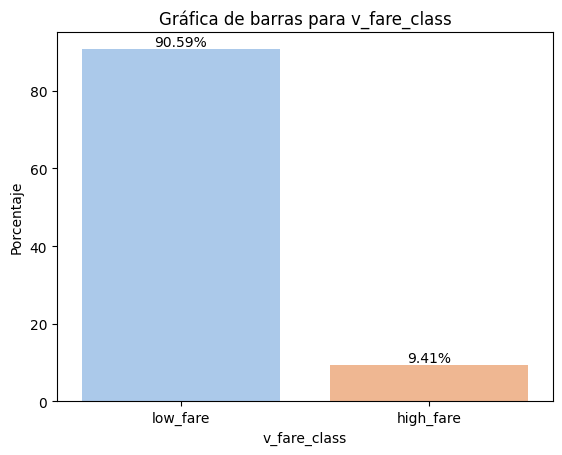

In [63]:
prop = df['v_fare_class'].value_counts(normalize=True) * 100

ax = sns.barplot(x=prop.index, y=prop.values, palette = palette)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')


plt.xlabel('v_fare_class')
plt.ylabel('Porcentaje')
plt.title('Gráfica de barras para v_fare_class')

plt.show()

Text(0.5, 1.0, 'Histograma del monto de la tarifa')

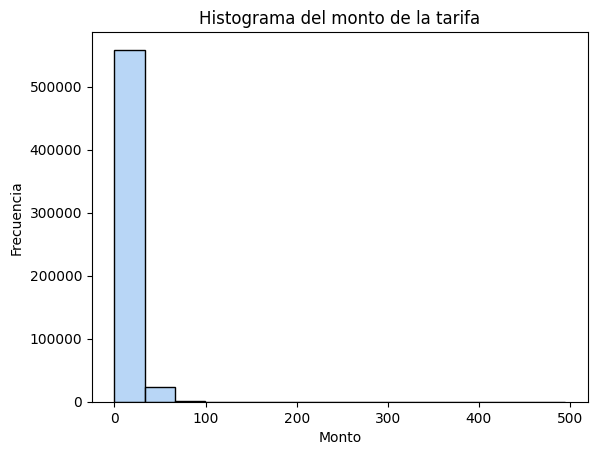

In [64]:
sns.histplot(data=df, x='c_fare_amount',bins = 15, color = palette[0])

plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.title('Histograma del monto de la tarifa')

En la gráfica anterior vemos posibles datos atipicos, vamos a omitir estos datos para tener una mejor vision del histogramam, en el siguiente histograma observamos que la distribución es asimetrica hacia la derecha, y se ve una distribucion de cola ligera

Text(0.5, 1.0, 'Histograma del monto de la tarifa')

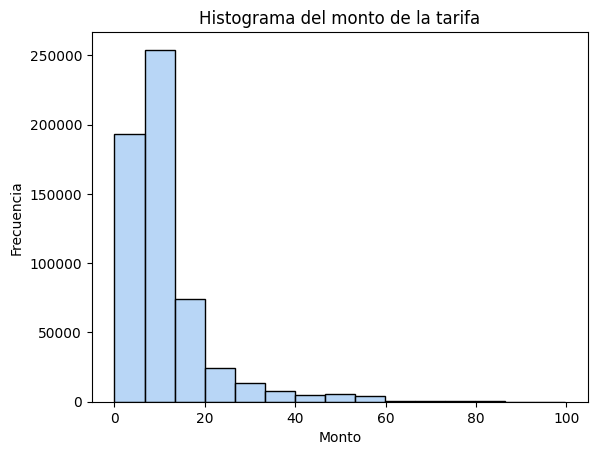

In [65]:
sns.histplot(data=df.loc[df['c_fare_amount'] < 100], x='c_fare_amount',bins = 15, color = palette[0])

plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.title('Histograma del monto de la tarifa')

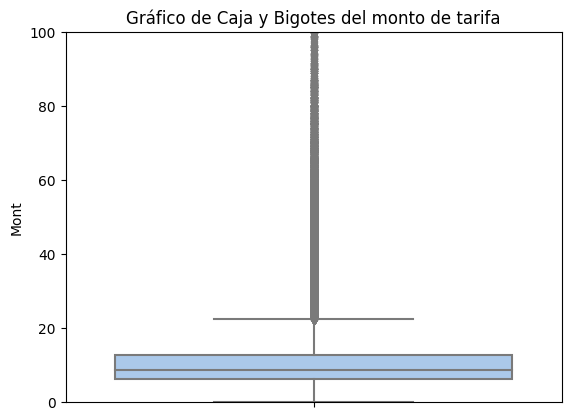

In [66]:
ax = sns.boxplot(y='c_fare_amount', data=df,palette=palette)
ax.set_ylim(0, 100)
plt.xlabel('')
plt.ylabel('Mont')
plt.title('Gráfico de Caja y Bigotes del monto de tarifa')

plt.show()

In [67]:
df['c_fare_amount'].describe() 

count    582844.000000
mean         11.366714
std           9.766948
min           0.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         495.000000
Name: c_fare_amount, dtype: float64

en la grafica anterior de caja y bigotes y en las estadisticas podemos observar que el 75% del monto se encuentra entre 0 y 12.5,como ya vimos anteriormente hay muchos datos extremos y se aprecia más en el grafico de caja y bigotes, en la siguiente gráfica podemos ver que los datos extremos justamente pertenencen a la tarifa alto, lo cual quiere decir que aunque son datos extremos es correcto el monto, este monto se pudo deber a que el viaje fue largo o fue en un día festivo

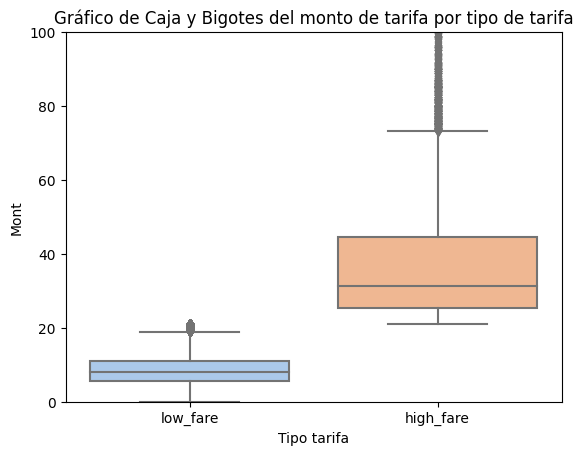

In [68]:
ax = sns.boxplot(x='v_fare_class',y='c_fare_amount', data=df,palette=palette)
ax.set_ylim(0, 100)
plt.xlabel('Tipo tarifa')
plt.ylabel('Mont')
plt.title('Gráfico de Caja y Bigotes del monto de tarifa por tipo de tarifa')

plt.show()

En la siguiente gráfica observamos que la mayoria de viajes solo los hacen con un pasajeros, el segundo caso más comun es con 2 pasajeros y luego los demas

Text(0.5, 1.0, 'Gráfica de barras de pasajeros')

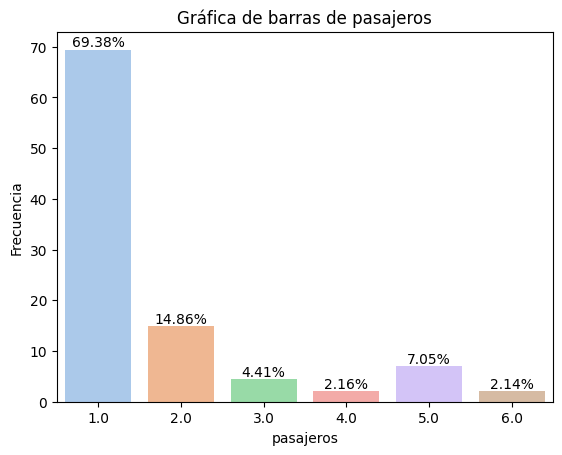

In [69]:
prop = df['c_passenger_count'].value_counts(normalize=True) * 100
ax = sns.barplot(x=prop.index, y=prop.values, palette = palette)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')


plt.xlabel('pasajeros')
plt.ylabel('Frecuencia')
plt.title('Gráfica de barras de pasajeros')

En la siguiente gráfica observamos que no hay una relación aparente entre el número de pasajeros y el monto de la tarifa, esto es logico pues en los taxis generalmente se cobra por la distancia recorrida y no por persona

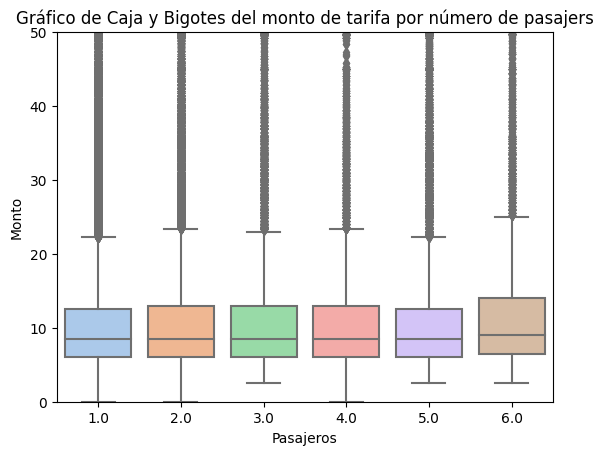

In [70]:

ax = sns.boxplot(x='c_passenger_count',y='c_fare_amount', data=df,palette=palette)
ax.set_ylim(0, 50)
plt.xlabel('Pasajeros')
plt.ylabel('Monto')
plt.title('Gráfico de Caja y Bigotes del monto de tarifa por número de pasajers')

plt.show()

En el siguiente gráfico podemos confirmar lo menciona, no hay mucha diferencia entre la distribucion de cuando hay 1,2,3,4,5 o 6 pasajeros

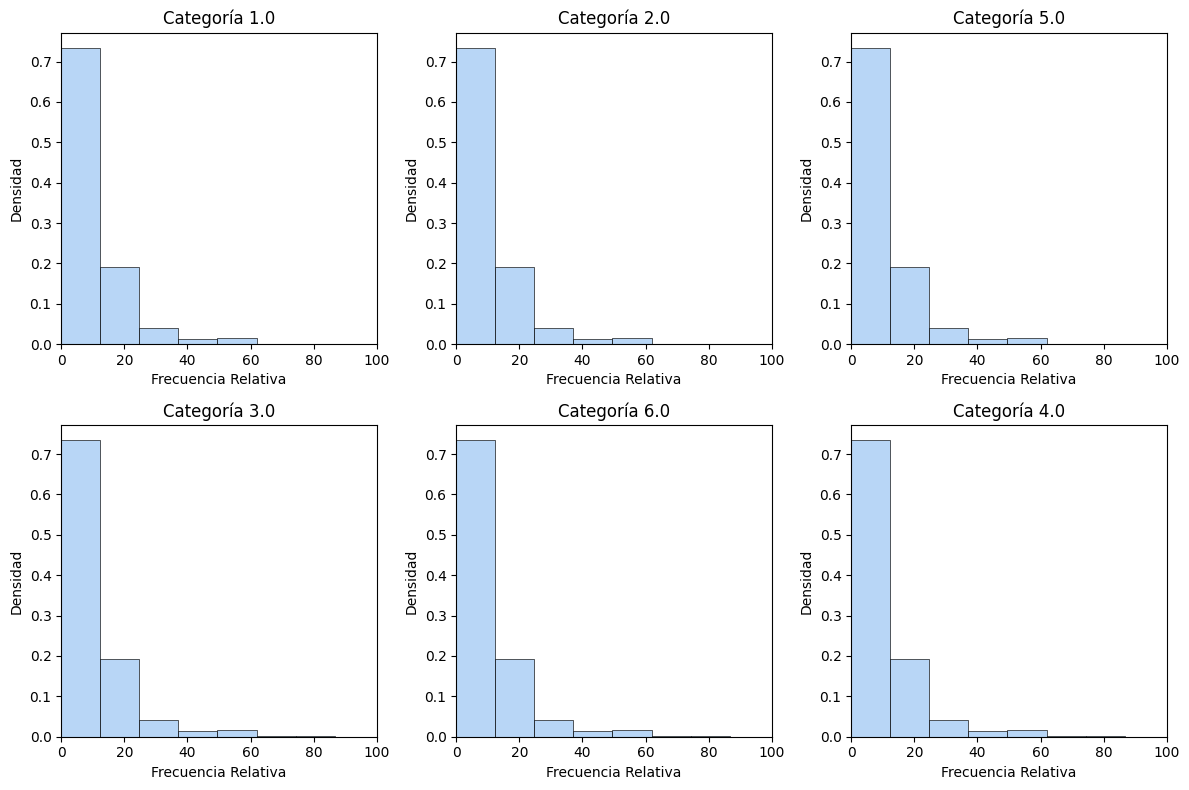

In [71]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
unic = df.loc[~df['c_passenger_count'].isnull(),'c_passenger_count'].unique()
for i, categoria in enumerate(unic):
    data_categoria = df[df['c_passenger_count'] == categoria]
    
    
    ax = sns.histplot(data=df['c_fare_amount'], ax=axes[i//3, i%3], bins=40, stat = 'probability', color = palette[0])
    ax.set_xlim(0, 100)
    axes[i//3, i%3].set_title(f'Categoría {categoria}')
    axes[i//3, i%3].set_xlabel('Frecuencia Relativa')
    axes[i//3, i%3].set_ylabel('Densidad')

plt.tight_layout()

plt.show()

vamos a hacer un agrupado por día para hacer un analisis del numero de viajes por día

In [72]:
agrupado_por_dia = df.groupby(df['d_pickup_datetime'].dt.date)['d_pickup_datetime'].count().reset_index(name='num_registros')
agrupado_por_dia['d_pickup_datetime'] = pd.to_datetime(agrupado_por_dia['d_pickup_datetime'])

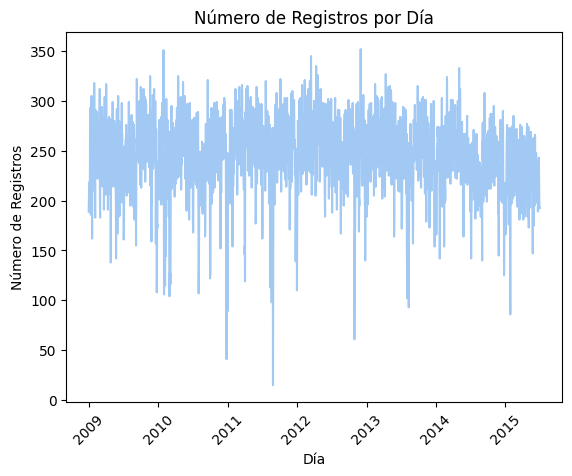

In [73]:
sns.lineplot(x="d_pickup_datetime", y="num_registros",data=agrupado_por_dia, color = palette[0])
plt.xlabel('Día')
plt.ylabel('Número de Registros')
plt.title('Número de Registros por Día')
plt.xticks(rotation=45) 

plt.show()

Se aprecia mucho ruido en la seríe anterior, pero podemos decir que no hay una tendencia aparente , la media y varianza parecen constantes(sobre todo la media, la varianza parece aumentar en ciertas fechas), vamos a hacer un grafico por mes, primero vamos a crear un nuevo dataframe ya agregar columnas como el mes, dia y dia de la semana, esto para analisis

In [74]:
df2 = df.copy()
df2['mes'] = df2['d_pickup_datetime'].dt.month
df2['dia_del_mes'] = df2['d_pickup_datetime'].dt.day
df2['dia_de_la_semana'] = df2['d_pickup_datetime'].dt.dayofweek
df2['hora'] = df2['d_pickup_datetime'].dt.hour
df2['es_fin_de_semana'] = (df2['d_pickup_datetime'].dt.dayofweek >= 5)
df2['mes_anio'] = df2['d_pickup_datetime'].dt.strftime('%Y-%m')
df2['anio'] = df2['d_pickup_datetime'].dt.year


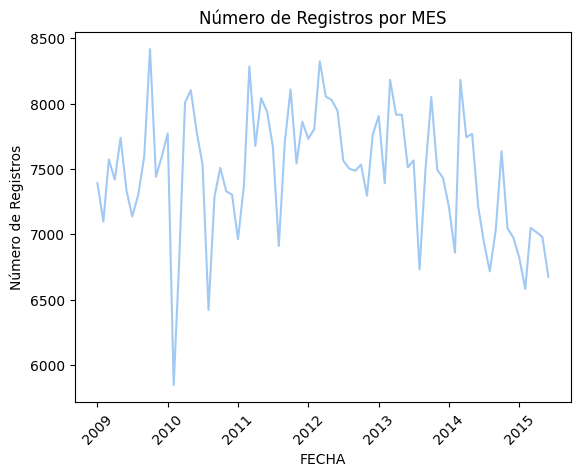

In [75]:
agrupado_por_mes = df2.groupby(df2['mes_anio'])['d_pickup_datetime'].count().reset_index(name='num_registros')
agrupado_por_mes['mes_anio'] = pd.to_datetime(agrupado_por_mes['mes_anio'])
sns.lineplot(x="mes_anio", y="num_registros",data=agrupado_por_mes, color = palette[0])
plt.xlabel('FECHA')
plt.ylabel('Número de Registros')
plt.title('Número de Registros por MES')
plt.xticks(rotation=45) 

plt.show()

vemos que hay temporadas donde aumenta y baja el número de viajes, podemos graficar un sesonalplot para apreciar si hay algun tipo de estacionalidad, en el siguiente grafico podemos ver que si hay cierto patron por mes, en febrero bajan la cantidad de viajes, suben en marzo,empiezan a bajar en julio - agosto y empiezan a subir en septiembre

/tmp/ipykernel_120359/2366654437.py:2: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.lineplot(x="mes", y="num_registros", hue="anio", data=agrupado_por_mes, palette=palette, markers=True, legend="full")


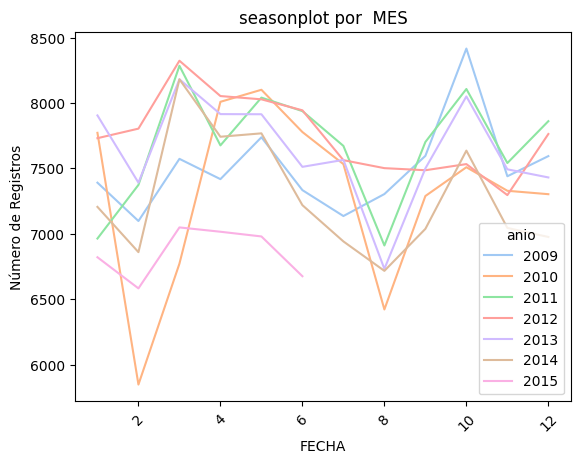

In [76]:
agrupado_por_mes = df2.groupby(['mes','anio'])['d_pickup_datetime'].count().reset_index(name='num_registros')
sns.lineplot(x="mes", y="num_registros", hue="anio", data=agrupado_por_mes, palette=palette, markers=True, legend="full")
plt.xlabel('FECHA')
plt.ylabel('Número de Registros')
plt.title('seasonplot por  MES')
plt.xticks(rotation=45) 

plt.show()

en el siguiente grafico se hace lo mismo por dia de més, sin embargo no se ve un patron como en los mese

/tmp/ipykernel_120359/1098254326.py:2: UserWarning: 
The palette list has fewer values (10) than needed (78) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(x="dia_del_mes", y="num_registros", hue='mes_anio', data=agrupado_por_mes, palette=palette, markers=True,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


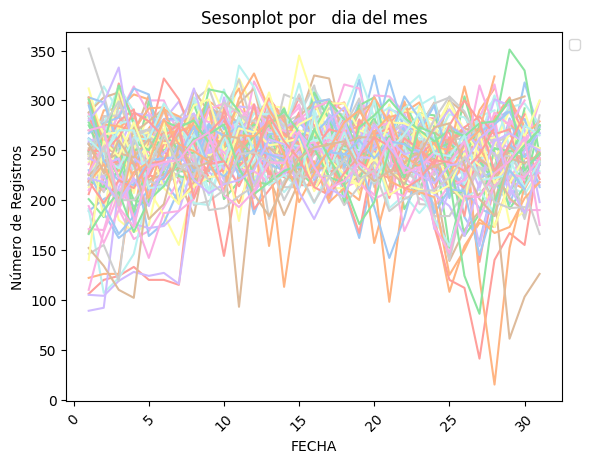

In [77]:
agrupado_por_mes = df2.groupby(['dia_del_mes','mes_anio'])['d_pickup_datetime'].count().reset_index(name='num_registros')
ax = sns.lineplot(x="dia_del_mes", y="num_registros", hue='mes_anio', data=agrupado_por_mes, palette=palette, markers=True,
                  legend=False)
ax.legend( loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('FECHA')
plt.ylabel('Número de Registros')
plt.title('Sesonplot por   dia del mes')
plt.xticks(rotation=45) 

plt.show()

en la siguiente grafica se muestra el promedio de monto por día, podemos ver una tendencia

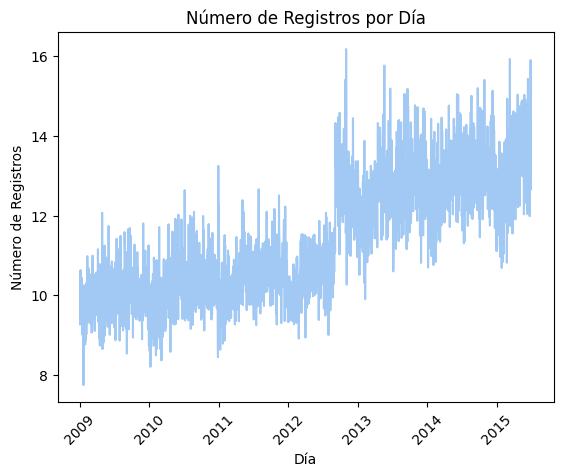

In [78]:
agrupado_por_dia = df.groupby(df['d_pickup_datetime'].dt.date)['c_fare_amount'].mean().reset_index(name='promedio')
agrupado_por_dia['d_pickup_datetime'] = pd.to_datetime(agrupado_por_dia['d_pickup_datetime'])
sns.lineplot(x="d_pickup_datetime", y="promedio",data=agrupado_por_dia, color = palette[0])
plt.xlabel('Día')
plt.ylabel('Número de Registros')
plt.title('Número de Registros por Día')
plt.xticks(rotation=45) 

plt.show()

En la siguiente gráfica de  autocorrelación y autocorrelacion parcial observamos que existe autoccorelacion en los promedios diarios (se diferencia la serie para eliminar tendencia al calcular ACF y PACF) , el ACF se trunca y el PACF decrede rapidamente, tambien vemos que alrededor del día 30 existen barras ligeramente significativas, y en 7 en ambos graficos tambien hay barras significativas, esto sifnifica que hay correlacion a n-1,n-7 y n-30 (o con el mismo día en el mes anterior)

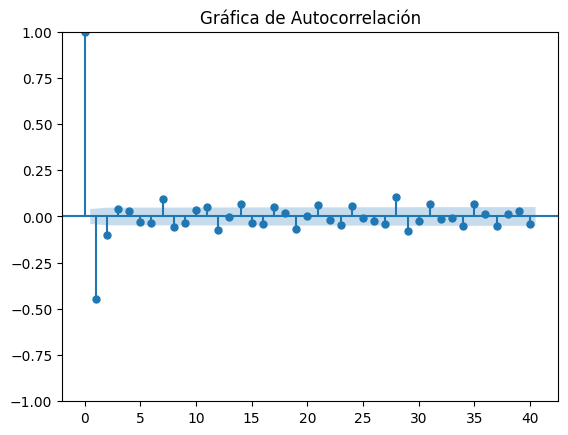

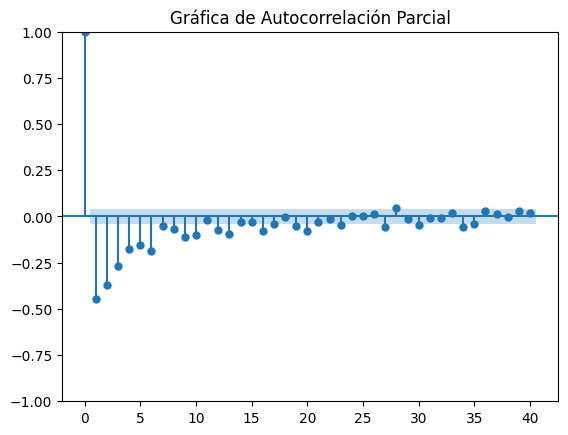

In [79]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
agrupado_por_dia = df.groupby(df['d_pickup_datetime'].dt.date)['c_fare_amount'].mean().reset_index(name='promedio')
agrupado_por_dia['d_pickup_datetime'] = pd.to_datetime(agrupado_por_dia['d_pickup_datetime'])
agrupado_por_dia['dif_prom'] = agrupado_por_dia['promedio'].diff()
agrupado_por_dia = agrupado_por_dia.loc[~agrupado_por_dia['dif_prom'].isnull()]
plot_acf(agrupado_por_dia['dif_prom'], lags=40)
plt.title('Gráfica de Autocorrelación')
plt.show()

# Gráfica de autocorrelación parcial
plot_pacf(agrupado_por_dia['dif_prom'], lags=40)
plt.title('Gráfica de Autocorrelación Parcial')
plt.show()

En el siguiente gráfico realizamos un promedio del monto por mes, vemos que aunque en la cantidad de viajes no hay tendencia, en el precio del monto si.

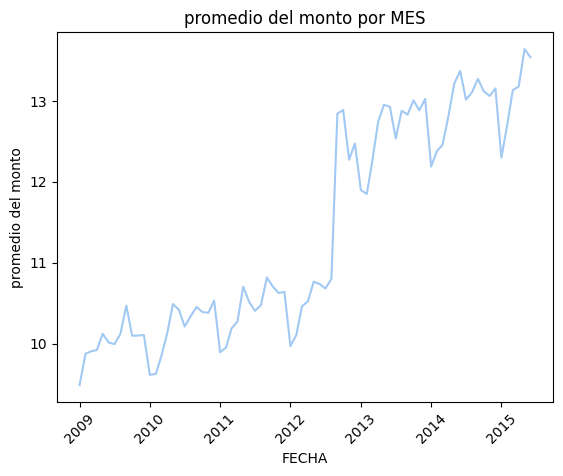

In [80]:
agrupado_por_mes = df2.groupby(df2['mes_anio'])['c_fare_amount'].mean().reset_index(name='promedio')
agrupado_por_mes['mes_anio'] = pd.to_datetime(agrupado_por_mes['mes_anio'])
sns.lineplot(x="mes_anio", y="promedio",data=agrupado_por_mes, color = palette[0])
plt.xlabel('FECHA')
plt.ylabel('promedio del monto')
plt.title('promedio del monto por MES')
plt.xticks(rotation=45) 

plt.show()

Tanto en la gráfica anterior como en la siguiente se ve un poco de estacionaliedad, en los primeros/ultimos meses del año el precio baja, y de junio a octubre los precios suben 

/tmp/ipykernel_120359/538766709.py:2: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  ax = sns.lineplot(x="mes", y="promedio", hue="anio", data=agrupado_por_mes, palette=palette, markers=True, legend="full")


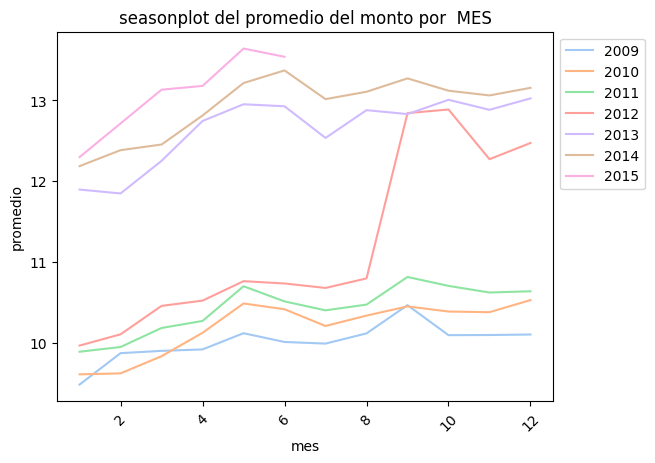

In [81]:
agrupado_por_mes = df2.groupby(['mes','anio'])['c_fare_amount'].mean().reset_index(name='promedio')
ax = sns.lineplot(x="mes", y="promedio", hue="anio", data=agrupado_por_mes, palette=palette, markers=True, legend="full")
ax.legend( loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('mes')
plt.ylabel('promedio')
plt.title('seasonplot del promedio del monto por  MES')
plt.xticks(rotation=45) 

plt.show()

En la gráfica de autocorrelacion y autocorrelación parcial apreciamos que hay una autocorrelacion en los promedios mensuales, en la ACF vemos una barra significativa al lag 6 y 12, y en el pacf en el lag 12, esto nos confirma la estacionalidad

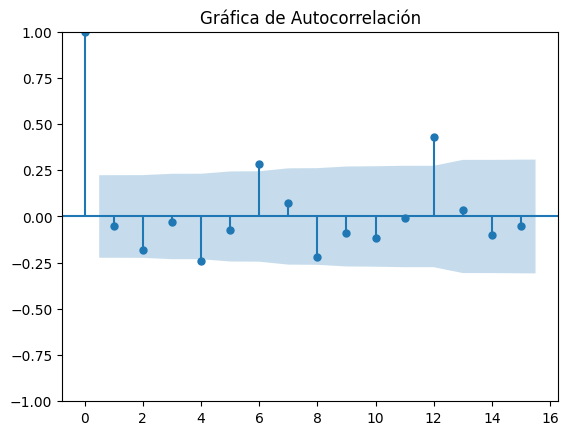

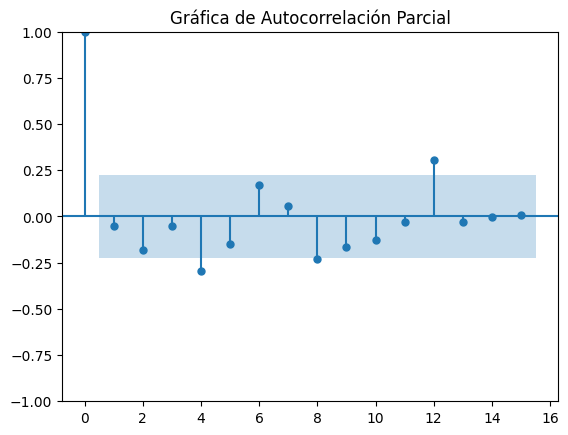

In [82]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
agrupado_por_mes = df2.groupby(df2['mes_anio'])['c_fare_amount'].mean().reset_index(name='promedio')
agrupado_por_mes['dif_prom'] = agrupado_por_mes['promedio'].diff()
agrupado_por_mes = agrupado_por_mes.loc[~agrupado_por_mes['dif_prom'].isnull()]
plot_acf(agrupado_por_mes['dif_prom'], lags=15)
plt.title('Gráfica de Autocorrelación')
plt.show()

# Gráfica de autocorrelación parcial
plot_pacf(agrupado_por_mes['dif_prom'], lags=15)
plt.title('Gráfica de Autocorrelación Parcial')
plt.show()

para el día del més no parece haber un patron, al igual que en la cantidad de viaes 

/tmp/ipykernel_120359/3780734629.py:2: UserWarning: 
The palette list has fewer values (10) than needed (78) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(x="dia_del_mes", y="promedio", hue='mes_anio', data=agrupado_por_mes, palette=palette, markers=True,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


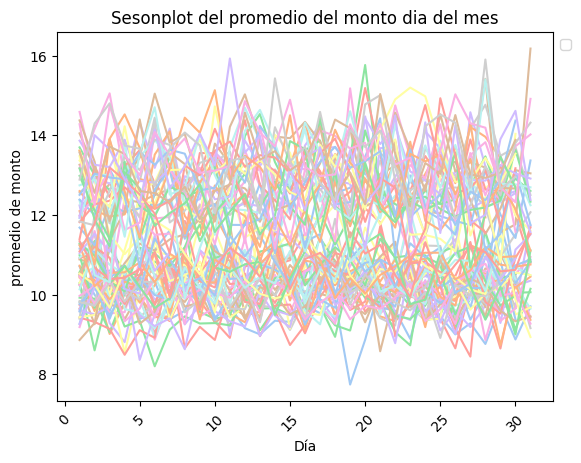

In [83]:
agrupado_por_mes = df2.groupby(['dia_del_mes','mes_anio'])['c_fare_amount'].mean().reset_index(name='promedio')
ax = sns.lineplot(x="dia_del_mes", y="promedio", hue='mes_anio', data=agrupado_por_mes, palette=palette, markers=True,
                  legend=False)
ax.legend( loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Día')
plt.ylabel('promedio de monto')
plt.title('Sesonplot del promedio del monto dia del mes')
plt.xticks(rotation=45) 

plt.show()

haciendo un diagrama de caja y bigotes por dia de la semana tampoco se ve que el día de la semana afecte en el precio de la tarif

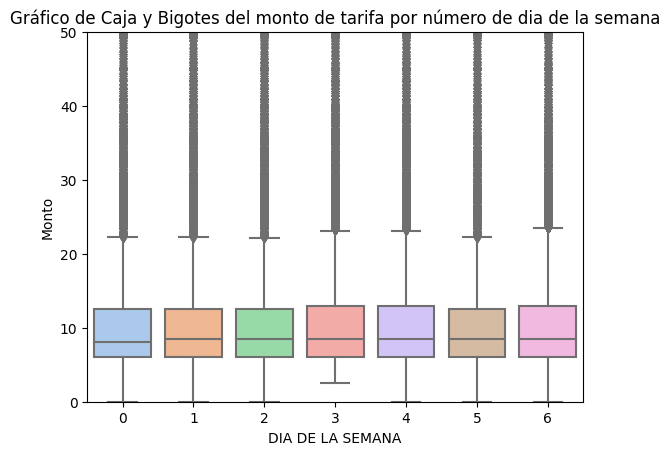

In [84]:
ax = sns.boxplot(x='dia_de_la_semana',y='c_fare_amount', data=df2,palette=palette)
ax.set_ylim(0, 50)
plt.xlabel('DIA DE LA SEMANA')
plt.ylabel('Monto')
plt.title('Gráfico de Caja y Bigotes del monto de tarifa por número de dia de la semana')

plt.show()

En el siguiente gráfico vemos que la horasi afecta en el monto de la tarifa, para horas entre las 12 y las vemos que las cajas son más grande abarcando más espacio hacia arriba, lo que indica que en estos horarios hay más variacion en los precios y son más comunes precios un poco altos

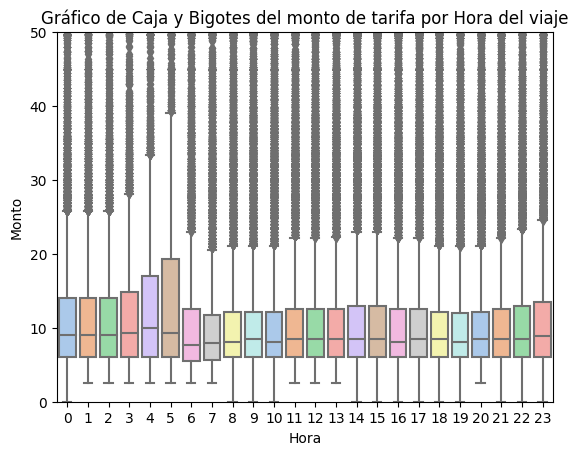

In [85]:
ax = sns.boxplot(x='hora',y='c_fare_amount', data=df2,palette=palette)
ax.set_ylim(0, 50)
plt.xlabel('Hora')
plt.ylabel('Monto')
plt.title('Gráfico de Caja y Bigotes del monto de tarifa por Hora del viaje')

plt.show()

Observamos que principalmente la hora y el més influyen en el precio del monto

**c_pickup_longitude y c_pickup_latitude**

revisemos una vista rapida de longitud vs latitud de inicio de viaje 

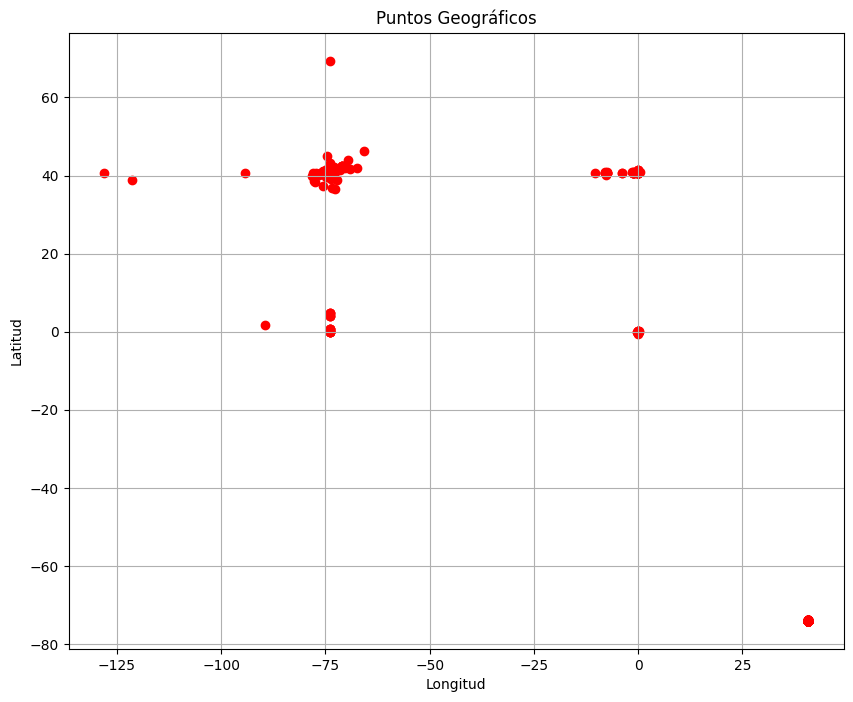

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(df['c_pickup_longitude'], df['c_pickup_latitude'], c='red', marker='o')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Puntos Geográficos')
plt.grid(True)
plt.show()

vemos que los datos estan muy dispersos, vamos a crear grupos y calcular la media de cada grupo, tomar ese punto como referencia y graficarlo en un mapa, promero creamos los grupos, tomando como referencia que aquellos que esten a menos de un umbral de distancia (0.1) pertenezcan a un grupo, si no, se excluyen del grupo

In [87]:
from scipy.spatial import cKDTree
from geopy.distance import great_circle
df2['Grupo1'] = -1
df2 = df2.loc[~((df2['c_pickup_longitude'].isnull()) | (df2['c_pickup_latitude'].isnull()) | (df2['c_dropoff_longitude'].isnull()) | (df2['c_dropoff_latitude'].isnull()))]
df3 = df2[['c_pickup_longitude','c_pickup_latitude','c_dropoff_longitude', 'c_dropoff_latitude','c_fare_amount']]
df3 = df3.drop_duplicates(subset=['c_pickup_latitude','c_pickup_longitude','c_dropoff_longitude', 'c_dropoff_latitude'], keep='first')

umbral_distancia = 0.1

def asignar_grupos(dataframe):
    grupos = np.full(len(dataframe), -1, dtype=int)
    grupo_counter = -1

    coordenadas = dataframe[['c_pickup_latitude', 'c_pickup_longitude']].values
    kdtree = cKDTree(coordenadas)
    for idx in range(len(dataframe)):
        if grupos[idx] == -1:
            grupo_counter += 1
            grupo_indices = kdtree.query_ball_point(coordenadas[idx], umbral_distancia)
            grupos[grupo_indices] = grupo_counter

    dataframe['Grupo1'] = grupos
    return dataframe

df3 = asignar_grupos(df3)

df3

,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_fare_amount,Grupo1
0,-73.956322,40.813427,-73.959143,40.783220,12.5,0
1,-73.982577,40.746018,-73.980713,40.780807,11.3,1
2,-73.972000,40.759470,-74.006190,40.708460,19.5,1
3,-74.002701,40.728209,-74.013599,40.710990,10.5,1
4,-73.982517,40.770782,-73.979932,40.754880,7.0,1
...,...,...,...,...,...,...
599993,-73.983923,40.758677,-73.986895,40.738637,7.3,1
599994,-73.986954,40.703197,-73.972633,40.780975,27.5,1
599995,-73.979120,40.746182,-74.004187,40.705937,14.5,1
599998,-73.973527,40.784913,-74.001877,40.740657,4.1,1


In [88]:
medias_grupo = df3.groupby('Grupo1')[['c_pickup_latitude','c_pickup_longitude','c_fare_amount']].mean().reset_index()
medias_grupo

,Grupo1,c_pickup_latitude,c_pickup_longitude,c_fare_amount
0,0,40.819117,-73.946740,12.788438
1,1,40.752269,-73.982279,10.295967
2,2,40.645290,-73.783901,44.001258
3,3,40.768438,-73.884386,25.091729
4,4,41.022502,-73.984257,3.700000
...,...,...,...,...
157,157,41.746891,-69.062927,14.500000
158,158,44.081344,-69.673548,10.000000
159,159,40.918670,0.551758,49.570000
160,160,39.689655,-74.972872,12.500000


relizamos una grafica sencilla y vemos practicamente la misma informacion que en el grafico con todos los registros

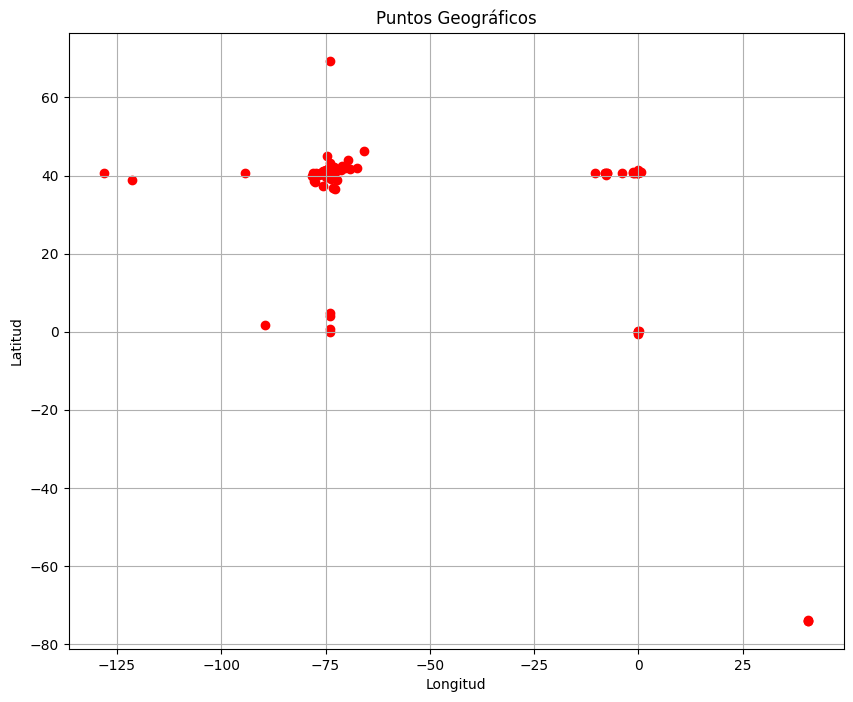

In [89]:
plt.figure(figsize=(10, 8))
plt.scatter(medias_grupo['c_pickup_longitude'], medias_grupo['c_pickup_latitude'], c='red', marker='o')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Puntos Geográficos')
plt.grid(True)
plt.show()

graficamos los puntos pero en un mapa para ver las ubicaciones de las coordenadas

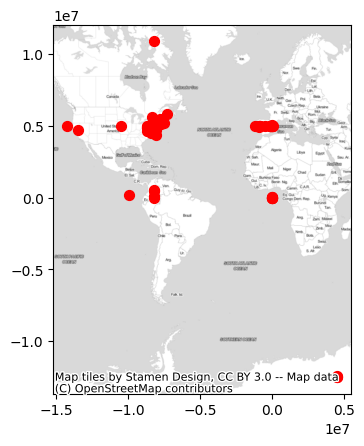

In [90]:
import geopandas
import contextily as ctx

gdf = geopandas.GeoDataFrame(
    medias_grupo, geometry=geopandas.points_from_xy(medias_grupo.c_pickup_longitude, medias_grupo.c_pickup_latitude), crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=3857)

# Crear un trazado con un mapa de fondo de OpenStreetMap.
ax = gdf.plot(marker='o', color='red', markersize=50)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

# Mostrar el trazado.
plt.show()

podemos ver que hay puntos que ni si quiera estan en la tierra, algunos otros estan en zonas donde ni los taxis llegan, evidentemente estos son datos incorrectos, por el monento centremosnos en los que estan en estados unidos 

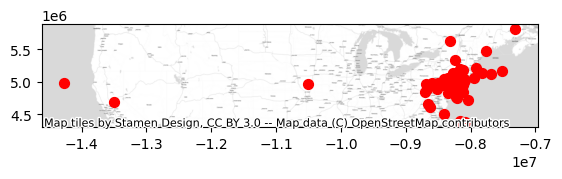

In [91]:
import geopandas
import contextily as ctx
medias_grupo = medias_grupo.loc[(medias_grupo['c_pickup_latitude'] < 60) & (medias_grupo['c_pickup_latitude'] > 20) &
                                (medias_grupo['c_pickup_longitude'] < -50)]
gdf = geopandas.GeoDataFrame(
    medias_grupo, geometry=geopandas.points_from_xy(medias_grupo.c_pickup_longitude, medias_grupo.c_pickup_latitude), crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=3857)

# Crear un trazado con un mapa de fondo de OpenStreetMap.
ax = gdf.plot(marker='o', color='red', markersize=50)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

# Mostrar el trazado.
plt.show()

evidentemente los datos de los taxis son de la zona de new york, los otros puntos lejos de new claramente son atipicos, cerremos más el espacio de visualización

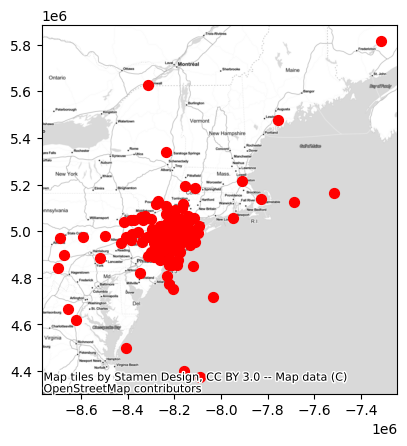

In [92]:
medias_grupo = medias_grupo.loc[(medias_grupo['c_pickup_latitude'] < 60) & (medias_grupo['c_pickup_latitude'] > 20) &
                                (medias_grupo['c_pickup_longitude'] < -50) & (medias_grupo['c_pickup_longitude'] > -85)]
gdf = geopandas.GeoDataFrame(
    medias_grupo, geometry=geopandas.points_from_xy(medias_grupo.c_pickup_longitude, medias_grupo.c_pickup_latitude), crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=3857)

# Crear un trazado con un mapa de fondo de OpenStreetMap.
ax = gdf.plot(marker='o', color='red', markersize=50)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

# Mostrar el trazado.
plt.show()

esta es la zona que tomaremos como correcta cuando tratemos datos atípicos, ahora vamos a colorear por el promedio del monto en ese punto geografico

/tmp/ipykernel_120359/1810488386.py:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


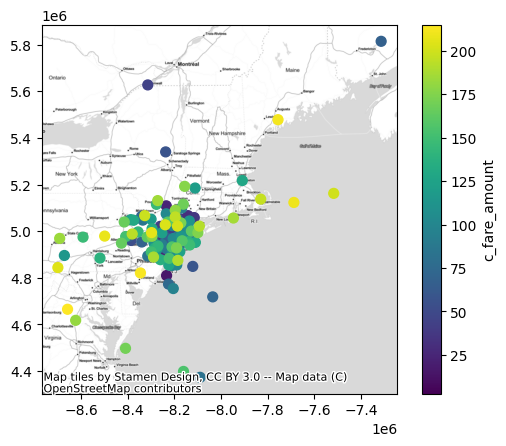

In [93]:
ax = gdf.plot(marker='o', cmap='viridis', markersize=50)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=gdf['c_fare_amount'].min(), vmax=gdf['c_fare_amount'].max()))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('c_fare_amount')

plt.show()

no se ve un patron claro en la relacion entre la ubicacion de origen y el monto, hagamos el mismo analisis para lod datos del destino 

In [94]:
df3['Grupo2'] = -1
umbral_distancia = 0.1

def asignar_grupos(dataframe):
    grupos = np.full(len(dataframe), -1, dtype=int)
    grupo_counter = -1

    coordenadas = dataframe[['c_dropoff_latitude', 'c_dropoff_longitude']].values
    kdtree = cKDTree(coordenadas)
    for idx in range(len(dataframe)):
        if grupos[idx] == -1:
            grupo_counter += 1
            grupo_indices = kdtree.query_ball_point(coordenadas[idx], umbral_distancia)
            grupos[grupo_indices] = grupo_counter

    dataframe['Grupo2'] = grupos
    return dataframe

df3 = asignar_grupos(df3)

medias_grupo = df3.groupby('Grupo2')[['c_dropoff_latitude','c_dropoff_longitude','c_fare_amount']].mean().reset_index()
medias_grupo

,Grupo2,c_dropoff_latitude,c_dropoff_longitude,c_fare_amount
0,0,40.778939,-73.958557,8.870706
1,1,40.711456,-73.880251,22.487638
2,2,40.657814,-73.798493,41.650975
3,3,40.584707,-73.959076,39.035172
4,4,40.741059,-73.983334,10.319425
...,...,...,...,...
170,170,44.077630,-69.817934,10.000000
171,171,42.017485,-86.804122,16.500000
172,172,39.651475,-74.981562,12.500000
173,173,40.750280,-9.633332,7.300000


/tmp/ipykernel_120359/3864663662.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


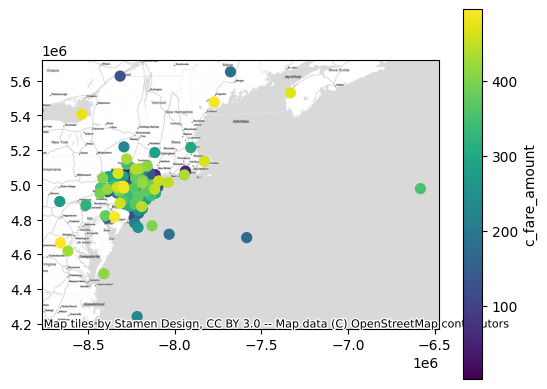

In [95]:
medias_grupo = medias_grupo.loc[(medias_grupo['c_dropoff_latitude'] < 55) & (medias_grupo['c_dropoff_latitude'] > 20) &
                                (medias_grupo['c_dropoff_longitude'] < -50) & (medias_grupo['c_dropoff_longitude'] > -80)]
gdf = geopandas.GeoDataFrame(
    medias_grupo, geometry=geopandas.points_from_xy(medias_grupo.c_dropoff_longitude, medias_grupo.c_dropoff_latitude), crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=3857)

ax = gdf.plot(marker='o', cmap='viridis', markersize=50)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=gdf['c_fare_amount'].min(), vmax=gdf['c_fare_amount'].max()))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('c_fare_amount')

plt.show()

de igual forma no se ve un patron claro, vamos a calcular la distabcia geodésica entre el origen y el destino ver como se comporta

In [96]:
from geopy.distance import geodesic
def calcular_distancia(row):
    origen = (row['c_pickup_latitude'], row['c_pickup_longitude'])
    destino = (row['c_dropoff_latitude'], row['c_dropoff_longitude'])
    distancia = geodesic(origen, destino).kilometers  
    return distancia

df2['Distancia'] = df2.apply(calcular_distancia, axis=1)

ahora que tenemos la distancia geodéstica realicemos un grafico de dispersion

/tmp/ipykernel_120359/2527279114.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(x='c_fare_amount', y='Distancia', data=df2, palette=palette)


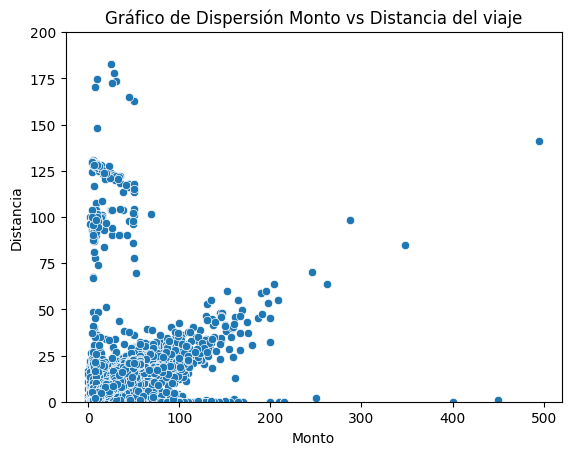

In [97]:
ax = sns.scatterplot(x='c_fare_amount', y='Distancia', data=df2, palette=palette)
plt.xlabel('Monto')
plt.ylabel('Distancia')
ax.set_ylim(0, 200)
plt.title('Gráfico de Dispersión Monto vs Distancia del viaje')


plt.show()

vemos que si hay una relación entre la distancia y el monto

# Outliers

El numero de pasajeros se ve correcto

Text(0.5, 1.0, 'Histograma del numero de pasajers')

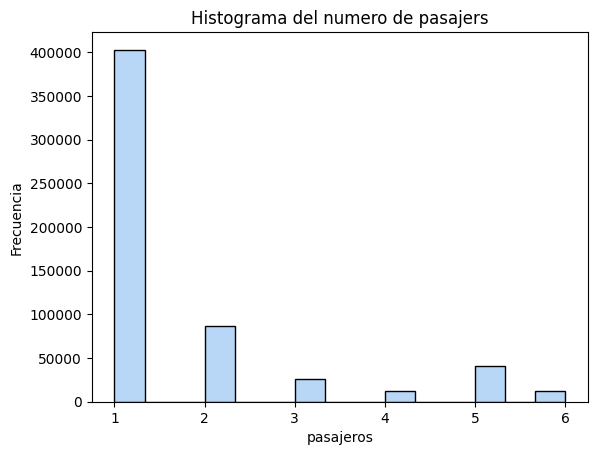

In [98]:
sns.histplot(data=df, x='c_passenger_count',bins = 15, color = palette[0])

plt.xlabel('pasajeros')
plt.ylabel('Frecuencia')
plt.title('Histograma del numero de pasajers')

para el monto si vemos datos atipicos 

Text(0.5, 1.0, 'Histograma del monto')

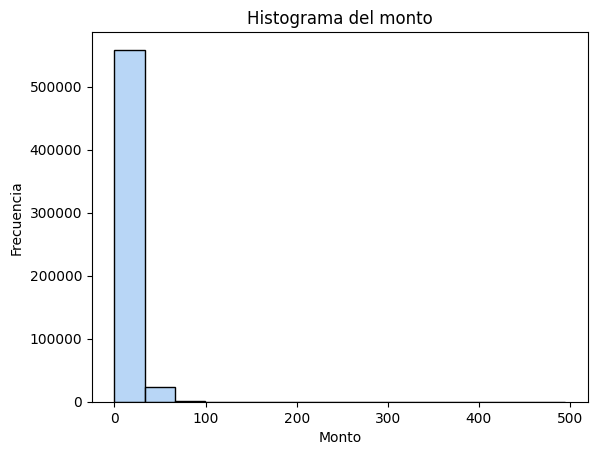

In [99]:
sns.histplot(data=df, x='c_fare_amount',bins = 15, color = palette[0])

plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.title('Histograma del monto')

para la longitud de recogida ya habíamos detectado datos atipicos, se ve claramente en el histograma

Text(0.5, 1.0, 'Histograma de la longitud de recogida')

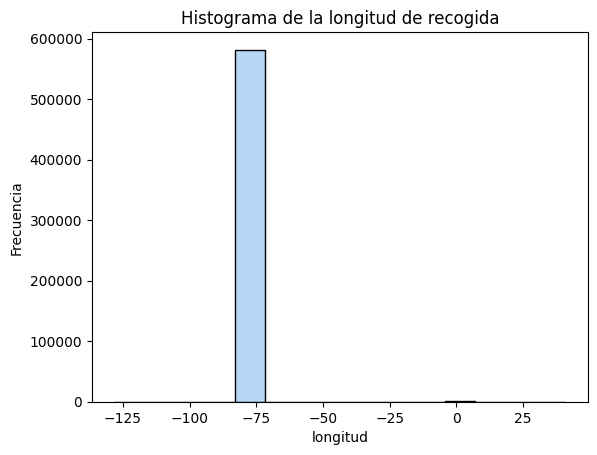

In [100]:
sns.histplot(data=df, x='c_pickup_longitude',bins = 15, color = palette[0])

plt.xlabel('longitud')
plt.ylabel('Frecuencia')
plt.title('Histograma de la longitud de recogida')

para la latitud tambien habiamos visto la presencia de atipicos

Text(0.5, 1.0, 'Histograma de la latitud de recogida')

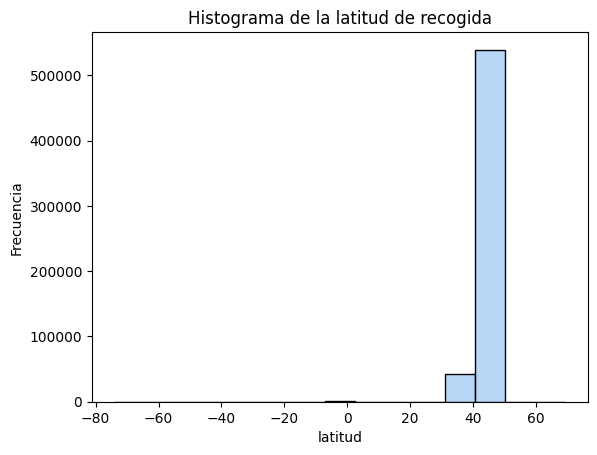

In [101]:
sns.histplot(data=df, x='c_pickup_latitude',bins = 15, color = palette[0])

plt.xlabel('latitud')
plt.ylabel('Frecuencia')
plt.title('Histograma de la latitud de recogida')

En los 2 siguientes graficos de igual forma vemos que en longitud y latitud de destino hay atipicos

Text(0.5, 1.0, 'Histograma de la longitud de destino')

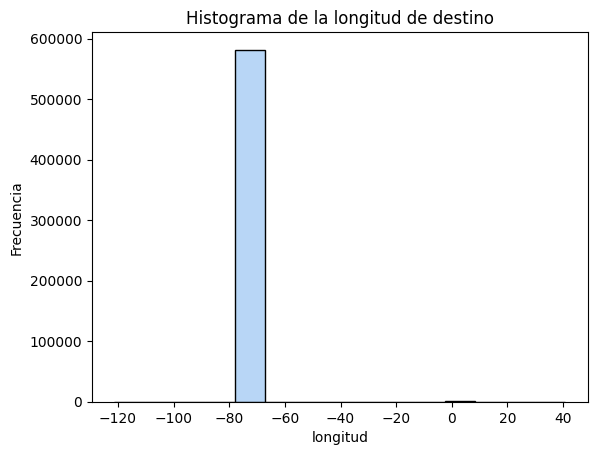

In [102]:
sns.histplot(data=df, x='c_dropoff_longitude',bins = 15, color = palette[0])

plt.xlabel('longitud')
plt.ylabel('Frecuencia')
plt.title('Histograma de la longitud de destino')

Text(0.5, 1.0, 'Histograma de la latitud de destino')

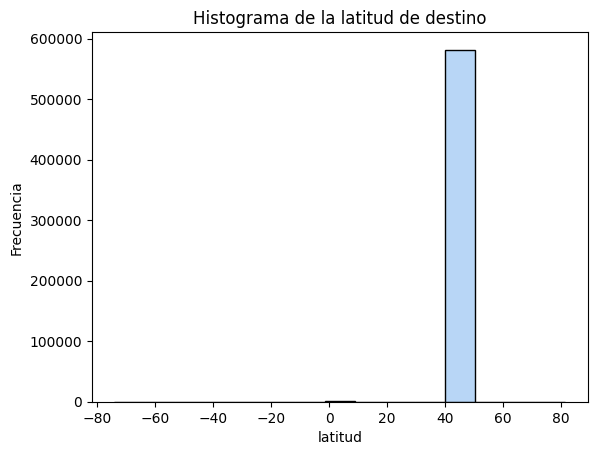

In [103]:
sns.histplot(data=df, x='c_dropoff_latitude',bins = 15, color = palette[0])

plt.xlabel('latitud')
plt.ylabel('Frecuencia')
plt.title('Histograma de la latitud de destino')

es importante ver que en los 4 graficos de coordenadas habia una pequeña barra en 0, posiblemente esto se deba a que algunos datos desconocidos se etiqueten en 0, revisemos los datos fuera del rango que consideramos correctos para la recogida

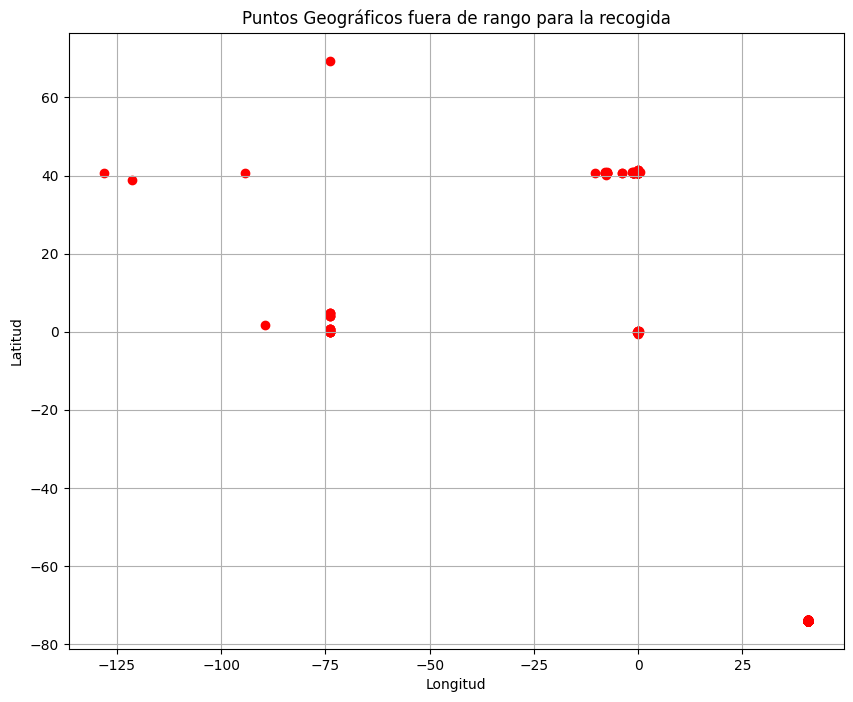

In [104]:

sub = df2.loc[~((df['c_pickup_latitude'] < 60) & (df['c_pickup_latitude'] > 20) &
              (df['c_pickup_longitude'] < -50) & (df['c_pickup_longitude'] > -85))]
plt.figure(figsize=(10, 8))
plt.scatter(sub['c_pickup_longitude'], sub['c_pickup_latitude'], c='red', marker='o')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Puntos Geográficos fuera de rango para la recogida')
plt.grid(True)
plt.show()


observamos que si graficamos una linea en exactamente 0 para la longitud y latitud hay varios puntos que encajan en una o las dos coordenadas

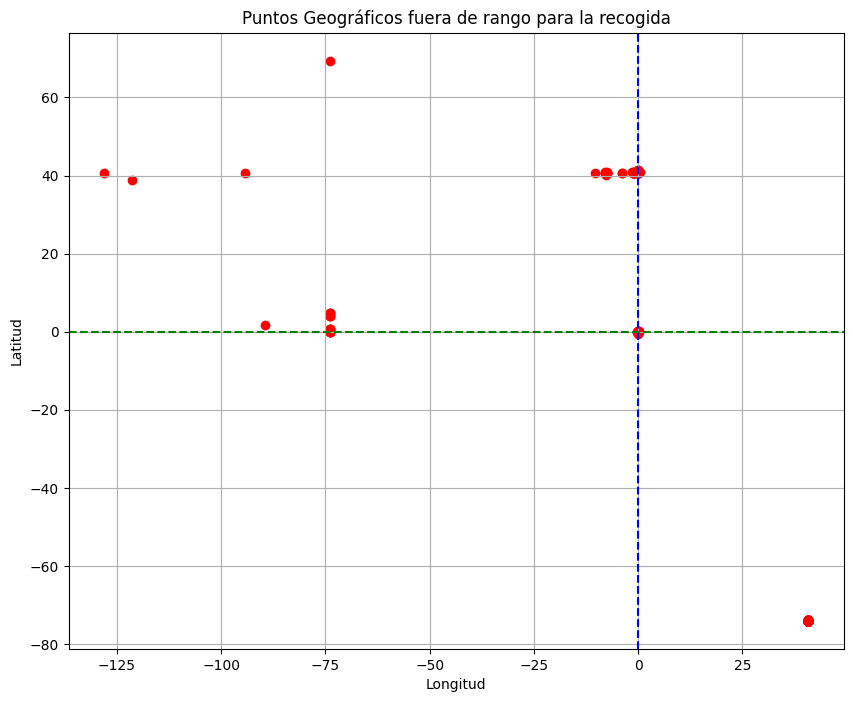

In [105]:
sub = df.loc[~((df['c_pickup_latitude'] < 60) & (df['c_pickup_latitude'] > 20) &
              (df['c_pickup_longitude'] < -50) & (df['c_pickup_longitude'] > -85))]
plt.figure(figsize=(10, 8))
plt.scatter(sub['c_pickup_longitude'], sub['c_pickup_latitude'], c='red', marker='o')
plt.axvline(0, color='blue', linestyle='--')
plt.axhline(0, color='green', linestyle='--')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Puntos Geográficos fuera de rango para la recogida')
plt.grid(True)
plt.show()

revisemos los casos donde una de las dos coordenadas o las dos son 0, observamos que para la recogida son 538 casos, en la tabla vemos casos donde incluso en el destino tiene ambas coordenadas en 0, esto no es algo logico, para empezar tenemos 5 digitos de precision, es dificil que  haya muchos viajes con exactamente el mismo punto de partida, habrá algunos cn diferencia minima pero encontrar más de 500 con casos donde es exacamente 0 la longitud y latitud nos indica que posiblemente el 0 se puso ya que desconocian el verdadero valor, esto más que un valor atipico cuenta como un valor desconocido (en  un caso real se tendría que validar con el cliente), así que estos casos se convierten a nul

In [106]:
sub2 = sub.loc[(sub['c_pickup_longitude'] == 0) | (sub['c_pickup_latitude'] == 0)]
sub2

,c_fare_amount,d_pickup_datetime,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,v_fare_class
2652,9.0,2015-02-08 19:51:55.000000200,0.0,0.0,-73.984909,40.756065,3.0,low_fare
2945,12.0,2013-03-16 03:22:56.000000100,0.0,0.0,-73.997673,40.746340,1.0,low_fare
3609,45.0,2009-03-27 05:38:00.000000150,0.0,0.0,-73.902590,40.764072,1.0,high_fare
3621,13.7,2010-04-05 11:08:55.000000300,0.0,0.0,-73.949670,40.757348,1.0,low_fare
4063,7.5,2015-01-10 18:55:24.000000800,0.0,0.0,-73.954727,40.781651,NaN,low_fare
...,...,...,...,...,...,...,...,...
591961,7.5,2015-02-19 22:21:49.000000800,0.0,0.0,-73.976341,40.764767,1.0,low_fare
592403,17.7,2010-05-04 15:20:01.000000400,0.0,0.0,-73.784542,40.741144,1.0,low_fare
594092,6.0,2013-01-20 14:51:43.000000300,0.0,0.0,-73.980277,40.767185,3.0,low_fare
596422,6.1,2012-05-02 10:27:56.000000300,0.0,0.0,-74.005111,40.751405,1.0,low_fare


In [107]:
df.loc[(df['c_pickup_longitude'] == 0) | (df['c_pickup_latitude'] == 0),['c_pickup_longitude','c_pickup_latitude']] = np.nan

revisamos los casos que  graficamente identificamos como atipicos hasta ahorita y son 395, obervamos que las medidas se ven logicas per invertidas, si vemos el grafico y los datos la longitud esta alrededor -73 mientras que la latitud esta alrededor de 40, en la siguiente tabla vemos que hay casos invertidos, es decir casos con longitud alredor de 40 y latitud alrededor de -73, esto es un posible error al ingresar los datos, vamos a intercambiar las columnas en estos caso y hacer de nuevo la distincion de atipicos

In [108]:
df.loc[((df['c_pickup_latitude'] > 60) | (df['c_pickup_latitude'] < 20) |
              (df['c_pickup_longitude'] > -50) | (df['c_pickup_longitude'] < -85))]

,c_fare_amount,d_pickup_datetime,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,v_fare_class
915,13.0,2013-05-22 15:33:00.000000175,40.766125,-73.983285,40.757417,-73.977962,2.0,low_fare
1778,10.0,2013-05-22 21:55:00.000000232,40.752880,-73.979505,40.780932,-73.956692,1.0,low_fare
4468,7.5,2013-05-22 22:37:00.000000180,40.764777,-73.981528,40.752527,-73.978142,1.0,low_fare
5401,10.9,2010-11-03 21:30:00.000000247,0.009560,0.018923,0.002328,0.016757,1.0,low_fare
9377,8.0,2013-05-22 11:10:00.000000760,40.739182,-73.999367,40.726190,-73.995187,1.0,low_fare
...,...,...,...,...,...,...,...,...
595033,5.0,2013-05-24 20:25:00.000000490,40.743437,-73.987770,40.741292,-73.997682,3.0,low_fare
595543,4.0,2013-05-25 01:46:00.000000500,40.766347,-73.964893,40.759655,-73.968235,6.0,low_fare
598366,13.5,2013-05-25 00:24:00.000000234,40.761150,-73.960817,40.797802,-73.961572,4.0,low_fare
599247,5.0,2013-05-22 15:12:00.000000580,40.757360,-73.985737,40.750142,-73.991370,1.0,low_fare


In [109]:
mask = ((df['c_pickup_latitude'] > 60) | (df['c_pickup_latitude'] < 20) |
        (df['c_pickup_longitude'] > -50) | (df['c_pickup_longitude'] < -85))

df.loc[mask, ['c_pickup_latitude', 'c_pickup_longitude']] = df.loc[mask, ['c_pickup_longitude', 'c_pickup_latitude']].values

los casos que sigan apareciendo como atipicos se vuelven a cambiar a su valor original 

In [110]:
mask = ((df['c_pickup_latitude'] > 60) | (df['c_pickup_latitude'] < 20) |
        (df['c_pickup_longitude'] > -50) | (df['c_pickup_longitude'] < -85))

df.loc[mask, ['c_pickup_latitude', 'c_pickup_longitude']] = df.loc[mask, ['c_pickup_longitude', 'c_pickup_latitude']].values

ahora tenemos solo 108 casos para estas 2 coordenadas 

In [111]:
df.loc[((df['c_pickup_latitude'] > 60) | (df['c_pickup_latitude'] < 20) |
              (df['c_pickup_longitude'] > -50) | (df['c_pickup_longitude'] < -85))]

,c_fare_amount,d_pickup_datetime,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,v_fare_class
5401,10.90,2010-11-03 21:30:00.000000247,0.009560,0.018923,0.002328,0.016757,1.0,low_fare
24772,4.90,2012-04-21 19:35:00.000000710,-73.976017,4.760552,-73.967532,40.768917,1.0,low_fare
29572,8.90,2011-01-08 18:32:00.000000181,0.000003,-0.026360,-0.003325,-0.031608,1.0,low_fare
31900,4.50,2012-02-14 22:12:00.000000169,-73.990205,4.090727,-74.001502,40.761990,1.0,low_fare
39162,6.10,2011-11-29 08:00:00.000000100,-0.132250,40.768440,-73.955195,40.768887,1.0,low_fare
...,...,...,...,...,...,...,...,...
577105,14.10,2012-03-13 18:51:00.000000820,-1.216667,40.750380,0.000000,0.000000,1.0,low_fare
584089,4.90,2010-12-11 15:41:00.000000196,-0.021537,-0.086092,-0.019510,-0.081445,5.0,low_fare
586966,49.80,2012-04-03 21:13:00.000000100,-0.183332,0.050000,-74.006610,40.734457,1.0,high_fare
587417,12.50,2011-12-18 02:18:00.000000200,-0.003482,40.732522,-73.978407,40.780610,1.0,low_fare


hacemos una gráfica rapida para ver como se ven estos atipicos

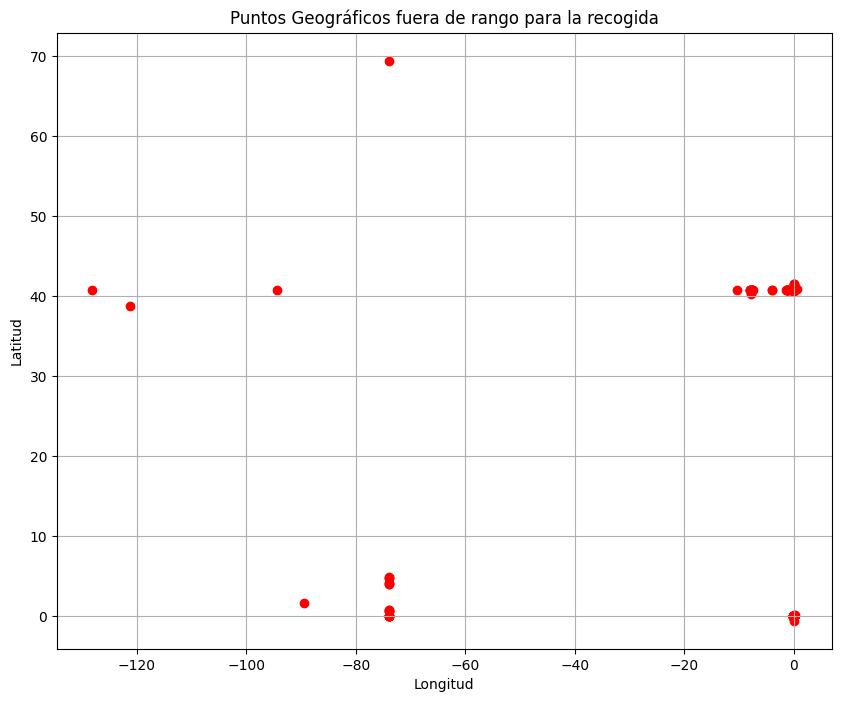

In [112]:
sub = df2.loc[~((df['c_pickup_latitude'] < 60) & (df['c_pickup_latitude'] > 20) &
              (df['c_pickup_longitude'] < -50) & (df['c_pickup_longitude'] > -85))]
plt.figure(figsize=(10, 8))
plt.scatter(sub['c_pickup_longitude'], sub['c_pickup_latitude'], c='red', marker='o')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Puntos Geográficos fuera de rango para la recogida')
plt.grid(True)
plt.show()


realizamos el mismo analisis pero para los datos de destino 

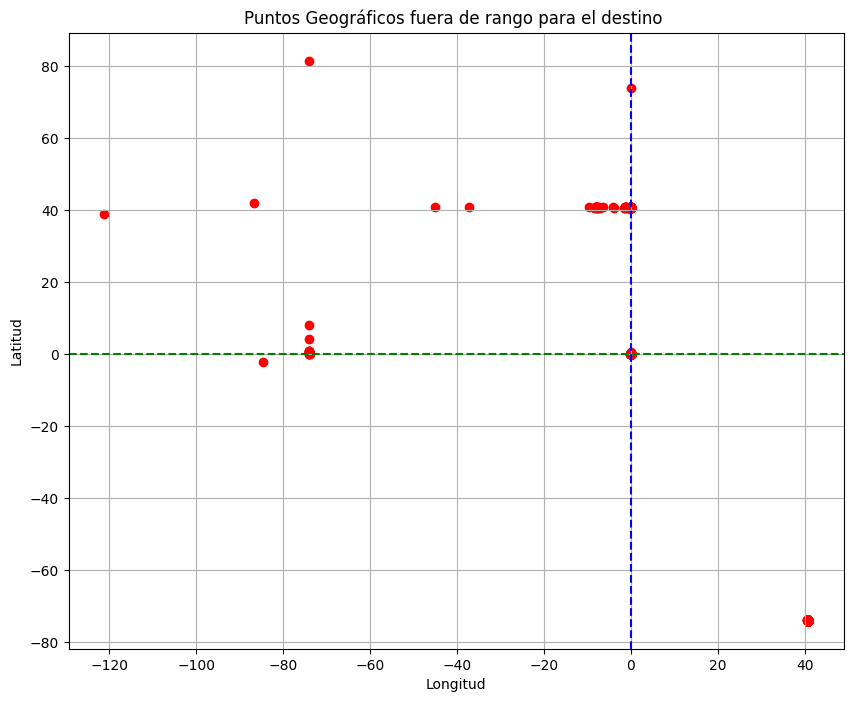

In [113]:
sub = df.loc[~((df['c_dropoff_latitude'] < 60) & (df['c_dropoff_latitude'] > 20) &
              (df['c_dropoff_longitude'] < -50) & (df['c_dropoff_longitude'] > -85))]
plt.figure(figsize=(10, 8))
plt.scatter(sub['c_dropoff_longitude'], sub['c_dropoff_latitude'], c='red', marker='o')
plt.axvline(0, color='blue', linestyle='--')
plt.axhline(0, color='green', linestyle='--')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Puntos Geográficos fuera de rango para el destino ')
plt.grid(True)
plt.show()

convertimos los casos con 0 en las cordenadas a Na

In [114]:
df.loc[(df['c_dropoff_longitude'] == 0) | (df['c_dropoff_latitude'] == 0),['c_dropoff_longitude','c_dropoff_latitude']] = np.nan

de igual forma, encontramos casos donde la longitud y lotitud se invirten, los intercambiamos 

In [115]:
df.loc[((df['c_dropoff_latitude'] > 60) | (df['c_dropoff_latitude'] < 20) |
              (df['c_dropoff_longitude'] > -50) | (df['c_dropoff_longitude'] < -85))]

,c_fare_amount,d_pickup_datetime,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,v_fare_class
915,13.0,2013-05-22 15:33:00.000000175,-73.983285,40.766125,40.757417,-73.977962,2.0,low_fare
1778,10.0,2013-05-22 21:55:00.000000232,-73.979505,40.752880,40.780932,-73.956692,1.0,low_fare
4468,7.5,2013-05-22 22:37:00.000000180,-73.981528,40.764777,40.752527,-73.978142,1.0,low_fare
5401,10.9,2010-11-03 21:30:00.000000247,0.009560,0.018923,0.002328,0.016757,1.0,low_fare
9377,8.0,2013-05-22 11:10:00.000000760,-73.999367,40.739182,40.726190,-73.995187,1.0,low_fare
...,...,...,...,...,...,...,...,...
595033,5.0,2013-05-24 20:25:00.000000490,-73.987770,40.743437,40.741292,-73.997682,3.0,low_fare
595543,4.0,2013-05-25 01:46:00.000000500,-73.964893,40.766347,40.759655,-73.968235,6.0,low_fare
598366,13.5,2013-05-25 00:24:00.000000234,-73.960817,40.761150,40.797802,-73.961572,4.0,low_fare
599247,5.0,2013-05-22 15:12:00.000000580,-73.985737,40.757360,40.750142,-73.991370,1.0,low_fare


In [116]:
mask = ((df['c_dropoff_latitude'] > 60)   | (df['c_dropoff_latitude'] < 20) |
        (df['c_dropoff_longitude'] > -50) | (df['c_dropoff_longitude'] < -85))

df.loc[mask, ['c_dropoff_latitude', 'c_dropoff_longitude']] = df.loc[mask, ['c_dropoff_longitude', 'c_dropoff_latitude']].values

mask = ((df['c_dropoff_latitude'] > 60)   | (df['c_dropoff_latitude'] < 20) |
        (df['c_dropoff_longitude'] > -50) | (df['c_dropoff_longitude'] < -85))

df.loc[mask, ['c_dropoff_latitude', 'c_dropoff_longitude']] = df.loc[mask, ['c_dropoff_longitude', 'c_dropoff_latitude']].values

ahora solo encontramos 116 casos de datos atipicos

In [117]:
df.loc[((df['c_dropoff_latitude'] > 60) | (df['c_dropoff_latitude'] < 20) |
              (df['c_dropoff_longitude'] > -50) | (df['c_dropoff_longitude'] < -85))]

,c_fare_amount,d_pickup_datetime,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,v_fare_class
5401,10.9,2010-11-03 21:30:00.000000247,0.009560,0.018923,0.002328,0.016757,1.0,low_fare
23057,4.9,2010-11-14 21:40:00.000000590,NaN,NaN,-73.960303,81.510177,1.0,low_fare
28679,9.7,2011-12-26 10:43:00.000000105,-73.946422,40.781045,-8.250000,40.754232,1.0,low_fare
29572,8.9,2011-01-08 18:32:00.000000181,0.000003,-0.026360,-0.003325,-0.031608,1.0,low_fare
31491,5.7,2012-02-12 22:15:00.000000130,-73.984640,40.759570,-7.589452,40.747552,2.0,low_fare
...,...,...,...,...,...,...,...,...
587990,5.7,2012-05-20 02:09:00.000000180,-73.982270,40.731162,-3.975357,40.717775,1.0,low_fare
589715,16.5,2013-07-31 22:07:51.000000200,-73.989094,40.726891,-86.804122,42.017485,3.0,low_fare
591204,7.3,2012-01-08 11:47:00.000000120,-73.988003,40.759785,-9.633332,40.750280,1.0,low_fare
593435,6.1,2011-12-11 11:23:00.000000189,-73.970828,40.761785,-0.128712,40.773487,1.0,low_fare


hacemos una grafica rapida

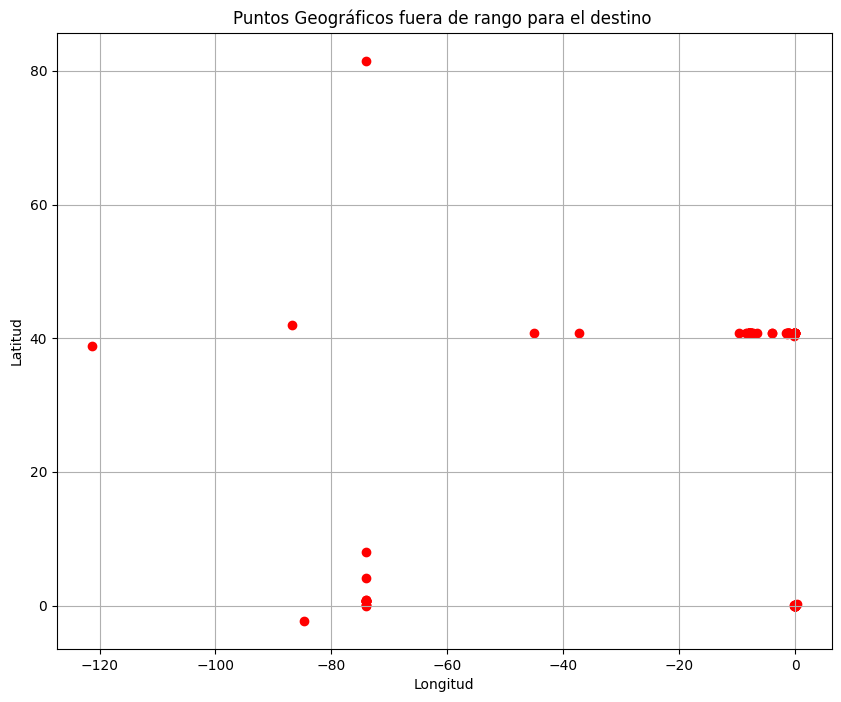

In [118]:
sub = df.loc[~((df['c_dropoff_latitude'] < 60) & (df['c_dropoff_latitude'] > 20) &
              (df['c_dropoff_longitude'] < -50) & (df['c_dropoff_longitude'] > -85))]
plt.figure(figsize=(10, 8))
plt.scatter(sub['c_dropoff_longitude'], sub['c_dropoff_latitude'], c='red', marker='o')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Puntos Geográficos fuera de rango para el destino ')
plt.grid(True)
plt.show()

In [119]:
def aux_outliers(a,b,c):
    a=set(a)
    b=set(b)
    c=set(c)
    a_=a.intersection(b)

    b_=b.intersection(c)

    c_=a.intersection(c)

    outliers_index=list(set(list(a_)+list(b_)+list(c_)))
    return outliers_index
def OUTLIERS(df,cols):
    results=pd.DataFrame()
    data_iqr=df.copy()
    data_per=df.copy()
    total=[]
    total_per=[]
    total_z=[]
    indices_=[]

    for col in cols:
        #IQR
        Q1=df[col].quantile(0.25)
        Q3=df[col].quantile(0.75)
        IQR=Q3-Q1
        INF=Q1-1.5*(IQR)
        SUP=Q3+1.5*(IQR)
    
        
        n_outliers=df[(df[col] < INF) | (df[col] > SUP)].shape[0]
        total.append(n_outliers)
        indices_iqr=list(df[(df[col] < INF) | (df[col] > SUP)].index)        
        #Percentiles
        INF_pe=np.percentile(df[col].dropna(),5)
    
        SUP_pe=np.percentile(df[col].dropna(),95)
        n_outliers_per=df[(df[col] < INF_pe) | (df[col] > SUP_pe)].shape[0]
        total_per.append(n_outliers_per)
        indices_per=list(df[(df[col] < INF_pe) | (df[col] > SUP_pe)].index)
        
        #MEAN CHANGE
        
        perc_100 = [x / 100 for x in range(100)]
        dist = df[col].describe(perc_100).iloc[4:]
        change_dist = df[col].describe(perc_100).iloc[4:].diff()
        mean_change = df[col].describe(
            perc_100).iloc[4:].diff().mean()
        if change_dist["max"] > mean_change:
            ub = dist["max"] - mean_change
            if ub < dist["99%"]:
                ub = dist["99%"]
        else:
            ub = dist["max"]

        if change_dist["1%"] > mean_change:
            lb = dist["0%"] + mean_change
            if lb > dist["1%"]:
                lb = dist["1%"]
        else:
            lb = dist["0%"]
        n_total_z=df[(df[col] < lb) | (df[col] > ub)].shape[0]
        total_z.append(n_total_z)
        indices_z=list(df[(df[col] < lb) | (df[col] > ub)].index)
        
        indices_.append(aux_outliers(indices_iqr,indices_per,indices_z))
        
    results["features"]=cols
    results["n_outliers_IQR"]=total
    results["n_outliers_Percentil"]=total_per
    results["n_outliers_Mean_Change"]=total_z
    results["n_outliers_IQR_%"]=round((results["n_outliers_IQR"]/df.shape[0])*100,2)
    results["n_outliers_Percentil_%"]=round((results["n_outliers_Percentil"]/df.shape[0])*100,2)
    results["n_outliers_Mean_Change_%"]=round((results["n_outliers_Mean_Change"]/df.shape[0])*100,2)
    results["indices"]=indices_
    results["total_outliers"]=results["indices"].map(lambda x:len(x))
    results["%_outliers"]=results["indices"].map(lambda x:round(((len(x)/df.shape[0])*100),2))
    results=results[['features', 'n_outliers_IQR', 'n_outliers_Percentil',
       'n_outliers_Mean_Change', 'n_outliers_IQR_%', 'n_outliers_Percentil_%',
       'n_outliers_Mean_Change_%',  'total_outliers', '%_outliers','indices']]
    return results

ahora vamos a  ejecutar la funcion que nos detecta datos atipicos por metodos univariables, esto solo lo aplicaremos a c_fare_amount ya que para las coordenadas utilizaremos metodos multivariados

In [120]:
outliers=OUTLIERS(df,['c_fare_amount'])

In [121]:
outliers

,features,n_outliers_IQR,n_outliers_Percentil,n_outliers_Mean_Change,n_outliers_IQR_%,n_outliers_Percentil_%,n_outliers_Mean_Change_%,total_outliers,%_outliers,indices
0,c_fare_amount,50541,54980,1,8.67,9.43,0.0,29141,5.0,"[393227, 262166, 524317, 393246, 29, 131102, 3..."


se encontraron 29141, que representan casi el 5% del total original, recordemos que llevamos aprox 3% de datos eliminados por lo que tendríamos poco menos del 8% de registros eliminados hasta este momento

In [122]:
outliers.total_outliers/tot_registos

0    0.048568
Name: total_outliers, dtype: float64

In [123]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

def OUTLIERS_MULTI(df,cols):
    results=pd.DataFrame()
    total_GRAF=[]
    total_LOF=[]
    total_IF=[]
    indices_=[]
    for col in cols:
        # LOF
        df2 = df[col].dropna()
        model = LocalOutlierFactor(n_neighbors= 4, metric = "euclidean", contamination = 0.002)
        res = model.fit_predict(df2[col])
        n_outliers_lof = np.sum(res <=-1)
        total_LOF.append(n_outliers_lof)
        indices_lof = df2.iloc[np.where(res <=-1)].index

        # IsolationForest
        max_features=df2.shape[1]
        n_estimators=50
        max_samples='auto'
        contamination=float(0.002)
        model2=IsolationForest(max_features = max_features, n_estimators=n_estimators, max_samples=max_samples, contamination=contamination)
        res2 = model2.fit_predict(df2[col])
        n_outliers_if = np.sum(res2 <=-1)
        total_IF.append(n_outliers_if)
        indices_if = df2.iloc[np.where(res2 <=-1)].index

        # metodo grafico
        res3 = df2.loc[(df2.iloc[:, 0] > -50) | (df2.iloc[:, 0] < -85) | (df2.iloc[:, 1] < 20) | (df2.iloc[:, 1] > 60) ] 
        n_outliers_graf = len(res3)
        total_GRAF.append(n_outliers_graf)
        indices_graf = res3.index

        indices_.append(aux_outliers(indices_lof,indices_if,indices_graf))
    
    results["features"]=cols
    results["n_outliers_LOF"]=total_LOF
    results["n_outliers_IF"]=total_IF
    results["n_outliers_GRAF"]=total_GRAF
    results["n_outliers_LOF_%"]=round((results["n_outliers_LOF"]/df.shape[0])*100,2)
    results["n_outliers_IF_%"]=round((results["n_outliers_IF"]/df.shape[0])*100,2)
    results["n_outliers_GRAF_%"]=round((results["n_outliers_GRAF"]/df.shape[0])*100,2)
    results["indices"]=indices_
    results["total_outliers"]=results["indices"].map(lambda x:len(x))
    results["%_outliers"]=results["indices"].map(lambda x:round(((len(x)/df.shape[0])*100),2))
    results=results[['features', 'n_outliers_LOF', 'n_outliers_IF',
       'n_outliers_GRAF', 'n_outliers_LOF_%', 'n_outliers_IF_%',
       'n_outliers_GRAF_%',  'total_outliers', '%_outliers','indices']]
    return results

        


        
ouliers_multi = OUTLIERS_MULTI(df,[['c_pickup_longitude','c_pickup_latitude'],['c_dropoff_longitude','c_dropoff_latitude']])

observamos que se encontraron 106 outliers para c_pickup_longitude, c_pickup_latitude y 102 para c_dropoff_longitude, c_dropoff_latitude

In [124]:
ouliers_multi

,features,n_outliers_LOF,n_outliers_IF,n_outliers_GRAF,n_outliers_LOF_%,n_outliers_IF_%,n_outliers_GRAF_%,total_outliers,%_outliers,indices
0,"[c_pickup_longitude, c_pickup_latitude]",1165,1113,109,0.2,0.19,0.02,116,0.02,"[202756, 365576, 478737, 298527, 23073, 289314..."
1,"[c_dropoff_longitude, c_dropoff_latitude]",1165,1162,115,0.2,0.20,0.02,121,0.02,"[202756, 28679, 365576, 538123, 539151, 295951..."


veamos en conjunto cuantos datos se tienen que eliminar, consideranto estos outliers y los outliers para c_fare_amount

In [125]:
from  functools import reduce
indices=list(ouliers_multi["indices"].values + outliers["indices"].values)
indices=list(set(reduce(lambda x,y: x+y, indices)))
len(indices)

29287

esto reprenta cerca del 5% lo cual es aceptable, procedemos a eliminarlos

In [126]:
df=df[~df.index.isin(indices)].reset_index(drop=True)

In [127]:
df

,c_fare_amount,d_pickup_datetime,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,v_fare_class
0,12.5,2012-11-11 13:45:00.000000290,-73.956322,40.813427,-73.959143,40.783220,1.0,low_fare
1,11.3,2010-01-26 00:13:00.000000500,-73.982577,40.746018,-73.980713,40.780807,1.0,low_fare
2,19.5,2014-10-07 19:24:00.000000235,-73.972000,40.759470,-74.006190,40.708460,2.0,low_fare
3,10.5,2012-10-20 13:48:40.000000200,-74.002701,40.728209,-74.013599,40.710990,1.0,low_fare
4,7.0,2014-04-29 20:27:00.000000186,-73.982517,40.770782,-73.979932,40.754880,1.0,low_fare
...,...,...,...,...,...,...,...,...
553552,7.3,2012-02-21 19:50:00.000000256,-73.983923,40.758677,-73.986895,40.738637,1.0,low_fare
553553,27.5,2015-06-27 12:47:27.000000700,-73.986954,40.703197,-73.972633,40.780975,1.0,high_fare
553554,14.5,2010-07-20 09:21:00.000000520,-73.979120,40.746182,-74.004187,40.705937,1.0,low_fare
553555,4.1,2010-09-13 13:28:00.000000138,-73.973527,40.784913,-74.001877,40.740657,6.0,low_fare


In [128]:
idx = df.loc[((df['c_dropoff_latitude'] > 60) | (df['c_dropoff_latitude'] < 20) |
              (df['c_dropoff_longitude'] > -50) | (df['c_dropoff_longitude'] < -85)) |
              ((df['c_pickup_latitude'] > 60) | (df['c_pickup_latitude'] < 20) |
              (df['c_pickup_longitude'] > -50) | (df['c_pickup_longitude'] < -85))].index 

df=df[~df.index.isin(idx)].reset_index(drop=True)

Text(0.5, 1.0, 'Histograma del monto despues de imputar')

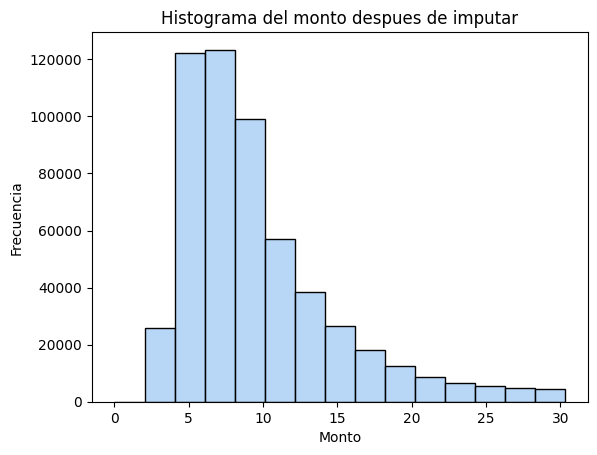

In [129]:
sns.histplot(data=df, x='c_fare_amount',bins = 15, color = palette[0])

plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.title('Histograma del monto despues de imputar')

Text(0.5, 1.0, 'Histograma de la longitud de recogida')

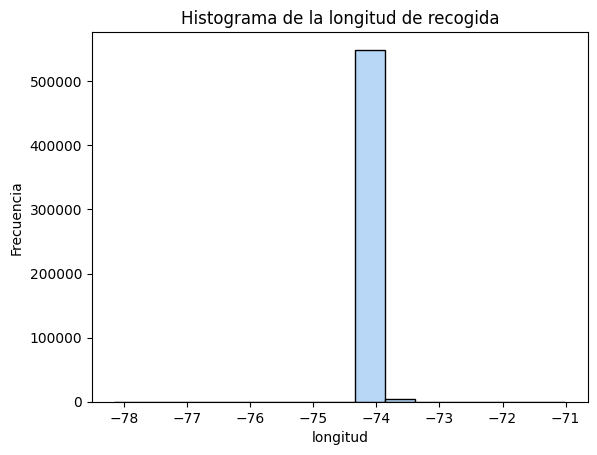

In [130]:
sns.histplot(data=df, x='c_pickup_longitude',bins = 15, color = palette[0])

plt.xlabel('longitud')
plt.ylabel('Frecuencia')
plt.title('Histograma de la longitud de recogida')

Text(0.5, 1.0, 'Histograma de la longitud de recogida')

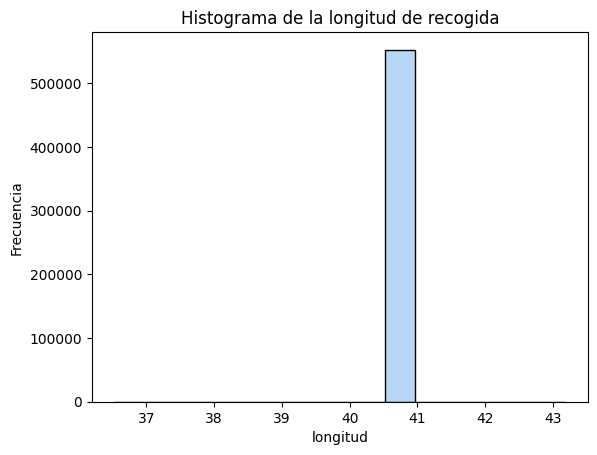

In [131]:
sns.histplot(data=df, x='c_pickup_latitude',bins = 15, color = palette[0])

plt.xlabel('longitud')
plt.ylabel('Frecuencia')
plt.title('Histograma de la longitud de recogida')

Text(0.5, 1.0, 'Histograma de la longitud de destino ')

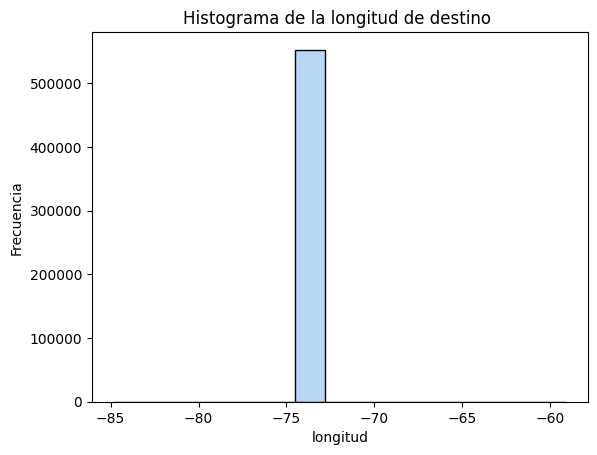

In [132]:
sns.histplot(data=df, x='c_dropoff_longitude',bins = 15, color = palette[0])

plt.xlabel('longitud')
plt.ylabel('Frecuencia')
plt.title('Histograma de la longitud de destino ')

Text(0.5, 1.0, 'Histograma de la longitud de destino ')

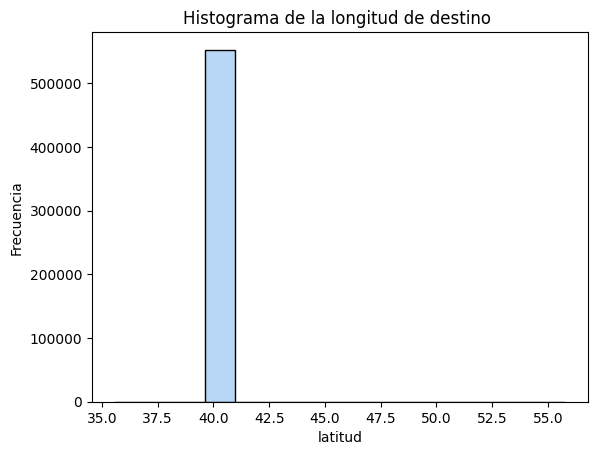

In [133]:
sns.histplot(data=df, x='c_dropoff_latitude',bins = 15, color = palette[0])

plt.xlabel('latitud')
plt.ylabel('Frecuencia')
plt.title('Histograma de la longitud de destino ')

todavia parece haber

In [134]:
df3 = df.copy()
df3['Grupo'] = -1
umbral_distancia = 0.1

def asignar_grupos(dataframe):
    grupos = np.full(len(dataframe), -1, dtype=int)
    grupo_counter = -1

    coordenadas = dataframe[['c_dropoff_latitude', 'c_dropoff_longitude']].values
    kdtree = cKDTree(coordenadas)
    for idx in range(len(dataframe)):
        if grupos[idx] == -1:
            grupo_counter += 1
            grupo_indices = kdtree.query_ball_point(coordenadas[idx], umbral_distancia)
            grupos[grupo_indices] = grupo_counter

    dataframe['Grupo'] = grupos
    return dataframe

df3 = asignar_grupos(df3)

medias_grupo = df3.groupby('Grupo')[['c_dropoff_latitude','c_dropoff_longitude','c_fare_amount']].mean().reset_index()

/tmp/ipykernel_120359/4228510487.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


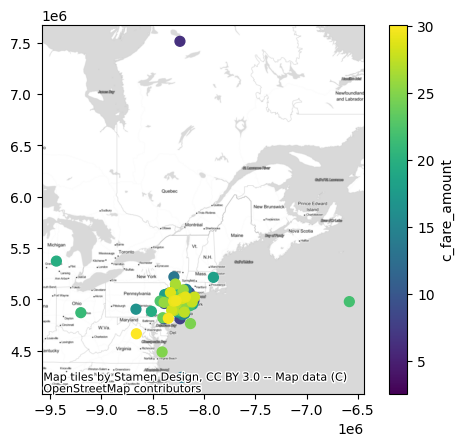

In [135]:

gdf = geopandas.GeoDataFrame(
    medias_grupo, geometry=geopandas.points_from_xy(medias_grupo.c_dropoff_longitude, medias_grupo.c_dropoff_latitude), crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=3857)

ax = gdf.plot(marker='o', cmap='viridis', markersize=50)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=gdf['c_fare_amount'].min(), vmax=gdf['c_fare_amount'].max()))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('c_fare_amount')

plt.show()

In [136]:

df3['Grupo2'] = -1
umbral_distancia = 0.1

def asignar_grupos(dataframe):
    grupos = np.full(len(dataframe), -1, dtype=int)
    grupo_counter = -1

    coordenadas = dataframe[['c_pickup_latitude', 'c_pickup_longitude']].values
    kdtree = cKDTree(coordenadas)
    for idx in range(len(dataframe)):
        if grupos[idx] == -1:
            grupo_counter += 1
            grupo_indices = kdtree.query_ball_point(coordenadas[idx], umbral_distancia)
            grupos[grupo_indices] = grupo_counter

    dataframe['Grupo2'] = grupos
    return dataframe

df3 = asignar_grupos(df3)

medias_grupo = df3.groupby('Grupo2')[['c_pickup_latitude','c_pickup_longitude','c_fare_amount']].mean().reset_index()

/tmp/ipykernel_120359/168111952.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


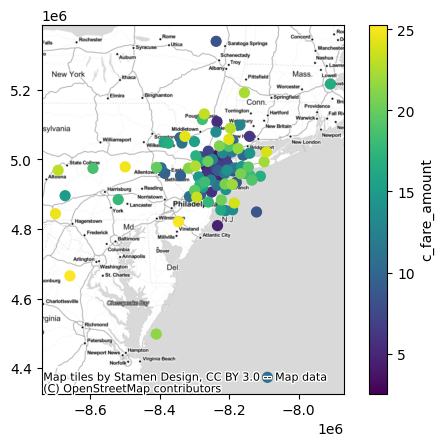

In [137]:

gdf = geopandas.GeoDataFrame(
    medias_grupo, geometry=geopandas.points_from_xy(medias_grupo.c_pickup_longitude, medias_grupo.c_pickup_latitude), crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=3857)

ax = gdf.plot(marker='o', cmap='viridis', markersize=50)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=gdf['c_fare_amount'].min(), vmax=gdf['c_fare_amount'].max()))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('c_fare_amount')

plt.show()

todavia parece haber ciertos datos atipicos en las ubicacines geograficas, pero si seguimos eliminando corremos el riesgo de eliminar demasiados registros, los registros de ahora son aceptables

# Missings

de nuevo revisemos los casos donde 4 o más variables son nulas, ya que esto no nos aporta informacion, estos datos los eliminamos, solo son 10 

In [138]:
len(df[df.isnull().sum(axis=1) >= 4]) / len(df)

1.806714110979221e-05

In [139]:
len(df[df.isnull().sum(axis=1) >= 4])

10

In [140]:
df = df.loc[df.isnull().sum(axis=1) < 4]
df

,c_fare_amount,d_pickup_datetime,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,v_fare_class
0,12.5,2012-11-11 13:45:00.000000290,-73.956322,40.813427,-73.959143,40.783220,1.0,low_fare
1,11.3,2010-01-26 00:13:00.000000500,-73.982577,40.746018,-73.980713,40.780807,1.0,low_fare
2,19.5,2014-10-07 19:24:00.000000235,-73.972000,40.759470,-74.006190,40.708460,2.0,low_fare
3,10.5,2012-10-20 13:48:40.000000200,-74.002701,40.728209,-74.013599,40.710990,1.0,low_fare
4,7.0,2014-04-29 20:27:00.000000186,-73.982517,40.770782,-73.979932,40.754880,1.0,low_fare
...,...,...,...,...,...,...,...,...
553486,7.3,2012-02-21 19:50:00.000000256,-73.983923,40.758677,-73.986895,40.738637,1.0,low_fare
553487,27.5,2015-06-27 12:47:27.000000700,-73.986954,40.703197,-73.972633,40.780975,1.0,high_fare
553488,14.5,2010-07-20 09:21:00.000000520,-73.979120,40.746182,-74.004187,40.705937,1.0,low_fare
553489,4.1,2010-09-13 13:28:00.000000138,-73.973527,40.784913,-74.001877,40.740657,6.0,low_fare


In [141]:
df.isnull().sum(axis=0)

c_fare_amount             0
d_pickup_datetime         0
c_pickup_longitude      471
c_pickup_latitude       471
c_dropoff_longitude     437
c_dropoff_latitude      435
c_passenger_count      2068
v_fare_class              0
dtype: int64

la variable que más datos nulos tiene es c_passenger_count, las demás son de poco menos de 500 

## conjunto de test y train 

In [227]:
from sklearn.model_selection import train_test_split
X_train,X_test=train_test_split(df,test_size=.3,random_state=13)

In [228]:
X_train.shape

(387436, 8)

In [229]:
X_test.shape

(166045, 8)

## imputación

vamos a crear un metodo de imputacion para las coordenadas el cual consiste predecir el valor NA a partir del destino/origen segun sea el caso usando una regresion lineal, por ejemplo para la variable c_pickup_longitude se predecirá a partir de c_dropoff_longitude y viceversa usando regresion lineal, y  para la variable c_pickup_latitude se predecirá a partir c_dropoff_latitude y viceversa, si la variable predictora es null se tomára el valor de la media de la target, por ejemplo si se trata de predecir c_pickup_longitude a partir de c_dropoff_longitude, y c_dropoff_longitude es null entonces se tomará en su lugar la media de c_pickup_longitude

In [230]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression

class ImputeLinearModelTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, predictor_col, target_col):
        self.predictor_col = predictor_col
        self.target_col = target_col
        
    def fit(self, X, y=None):
        
        filtered_data = X.dropna(subset=[self.predictor_col, self.target_col])
        X_with_pred = filtered_data[[self.predictor_col]]
        y_with_pred = filtered_data[self.target_col]
        
        # Calcular la media de la variable objetivo
        self.mean_target = X[self.target_col].mean()
        
        # Entrenar un modelo de regresión lineal
        self.model = LinearRegression()
        self.model.fit(X_with_pred, y_with_pred)
        
        return self

    def transform(self, X):
        # Hacer una copia de los datos
        X_copy = X.copy()
        
        # Filtrar filas con la variable objetivo nula y la variable predictora no nula
        missing_target_and_not_missing_pred = X_copy[self.target_col].isnull() & ~X_copy[self.predictor_col].isnull()
        
        # Imputar valores utilizando el modelo de regresión lineal donde la variable objetivo es nula
        X_missing_target = X_copy[missing_target_and_not_missing_pred][[self.predictor_col]]
        imputed_target = self.model.predict(X_missing_target)
        X_copy.loc[missing_target_and_not_missing_pred, self.target_col] = imputed_target
        
        # Imputar valores utilizando la media donde ambas la variable objetivo y la variable predictora son nulas
        X_copy.loc[X_copy[self.target_col].isnull() & X_copy[self.predictor_col].isnull(), self.target_col] = self.mean_target
        
        return X_copy

        
        return self


ya se creo la clase, ahora vamos a usarlo tal y como se usaria cualquier otro modelo 

In [231]:
X_imp = X_train.copy()

imputer = ImputeLinearModelTransformer(predictor_col='c_dropoff_longitude', target_col='c_pickup_longitude')
imputer.fit(X_imp)
X_imp = imputer.transform(X_imp)
imputer2 = ImputeLinearModelTransformer(predictor_col='c_pickup_longitude', target_col='c_dropoff_longitude')
imputer2.fit(X_imp)
X_imp = imputer2.transform(X_imp)
imputer3 = ImputeLinearModelTransformer(predictor_col='c_dropoff_latitude', target_col='c_pickup_latitude')
imputer3.fit(X_imp)
X_imp = imputer3.transform(X_imp)
imputer4 = ImputeLinearModelTransformer(predictor_col='c_pickup_latitude', target_col='c_dropoff_latitude')
imputer4.fit(X_imp)
X_imp = imputer4.transform(X_imp)

verifiquemos que no quedan nulos

In [232]:
print(np.sum(X_imp['c_pickup_longitude'].isnull()))
print(np.sum(X_imp['c_dropoff_longitude'].isnull()))
print(np.sum(X_imp['c_pickup_latitude'].isnull()))
print(np.sum(X_imp['c_dropoff_latitude'].isnull()))

0
0
0
0


Realicemos la prueba de bondad de ajuste de  Kolmogórov-Smirnov  para verificar que la distribucion de los datos sigue siendo la misma

In [233]:
from scipy import stats
originales=list(X_train['c_pickup_longitude'].dropna().values)
imputados=list(X_imp['c_pickup_longitude'].values)
print('ks c_pickup_longitude: ', stats.ks_2samp(originales,imputados))

originales=list(X_train['c_dropoff_longitude'].dropna().values)
imputados=list(X_imp['c_dropoff_longitude'].values)
print('ks c_dropoff_longitude: ', stats.ks_2samp(originales,imputados))

originales=list(X_train['c_pickup_latitude'].dropna().values)
imputados=list(X_imp['c_pickup_latitude'].values)
print('ks c_pickup_latitude: ', stats.ks_2samp(originales,imputados))

originales=list(X_train['c_dropoff_latitude'].dropna().values)
imputados=list(X_imp['c_dropoff_latitude'].values)
print('ks c_dropoff_latitude: ', stats.ks_2samp(originales,imputados))

ks c_pickup_longitude:  KstestResult(statistic=0.00024592176806281785, pvalue=1.0, statistic_location=-73.989863, statistic_sign=1)
ks c_dropoff_longitude:  KstestResult(statistic=0.00016555134290802132, pvalue=1.0, statistic_location=-73.990763, statistic_sign=1)
ks c_pickup_latitude:  KstestResult(statistic=0.0001763448543364854, pvalue=1.0, statistic_location=40.76201753095686, statistic_sign=-1)
ks c_dropoff_latitude:  KstestResult(statistic=0.00014907938459429726, pvalue=1.0, statistic_location=40.7676550879569, statistic_sign=-1)


en los 4 casos el p_value es alto, por lo tanto se considera que este metodo no cambia la distribucion de los datos y es un metodo aceptable para imputar, para la variable c_passenger_count se ocupara la moda y tambien se hará una prueba para verificar que la distribución no cambia, en este caso es la prueba $\chi^2$ ya que la variable c_passenger_count es discreta

In [234]:
from scipy.stats import chisquare
def chi_square(df,col,valor_miss):
    x_i=df[col].fillna(valor_miss).value_counts()
    k=x_i.sum()
    p_i=df[col].dropna().value_counts(1)
    m_i=k*p_i
    print(x_i)
    print(m_i)
    chi=chisquare(f_obs=x_i,f_exp=m_i)
    p_val=chi.pvalue
    alpha=0.05
    print('p_value', p_val)
    if p_val<alpha:
        print("Rechazamos HO(La porporción de categorias es la misma que la general)")
    else:
        print("Aceptamos HO(La porporción de categorias es la misma que la general)")

In [235]:
chi_square(X_train,"c_passenger_count",1)

c_passenger_count
1.0    270054
2.0     57003
5.0     27035
3.0     16882
4.0      8344
6.0      8118
Name: count, dtype: int64
c_passenger_count
1.0    269611.209721
2.0     57218.027639
5.0     27136.981864
3.0     16945.682554
4.0      8375.475372
6.0      8148.622851
Name: proportion, dtype: float64
p_value 0.7927792979244421
Aceptamos HO(La porporción de categorias es la misma que la general)


el p_value es alto, por lo tanto se puede la moda, ahora si procedemos a imputar los datos en los dataframes originales

In [236]:
from sklearn.impute import SimpleImputer
imputer = ImputeLinearModelTransformer(predictor_col='c_dropoff_longitude', target_col='c_pickup_longitude')
imputer.fit(X_train)
X_train = imputer.transform(X_train)
imputer2 = ImputeLinearModelTransformer(predictor_col='c_pickup_longitude', target_col='c_dropoff_longitude')
imputer2.fit(X_train)
X_train = imputer2.transform(X_train)
imputer3 = ImputeLinearModelTransformer(predictor_col='c_dropoff_latitude', target_col='c_pickup_latitude')
imputer3.fit(X_train)
X_train = imputer3.transform(X_train)
imputer4 = ImputeLinearModelTransformer(predictor_col='c_pickup_latitude', target_col='c_dropoff_latitude')
imputer4.fit(X_train)
X_train = imputer4.transform(X_train)
imputer5=SimpleImputer(missing_values=np.nan,strategy="most_frequent")
imputer5.fit(X_train[['c_passenger_count']])
X_train[["c_passenger_count"]]=imputer5.transform(X_train[["c_passenger_count"]])

ahor imputamos en los test

In [237]:
X_test = imputer.transform(X_test)
X_test = imputer2.transform(X_test)
X_test = imputer3.transform(X_test)
X_test = imputer4.transform(X_test)
X_test[["c_passenger_count"]]=imputer5.transform(X_test[["c_passenger_count"]])

In [238]:
X_test.isnull().sum(axis=0)

c_fare_amount          0
d_pickup_datetime      0
c_pickup_longitude     0
c_pickup_latitude      0
c_dropoff_longitude    0
c_dropoff_latitude     0
c_passenger_count      0
v_fare_class           0
dtype: int64

In [239]:
X_train.isnull().sum(axis=0)

c_fare_amount          0
d_pickup_datetime      0
c_pickup_longitude     0
c_pickup_latitude      0
c_dropoff_longitude    0
c_dropoff_latitude     0
c_passenger_count      0
v_fare_class           0
dtype: int64

# Ingeniería de variables

## Categoricas

la unica variable categorica es v_fare_class, pero esta variable se calcula a partir c_fare_amount, por lo tanto lo mejor será eliminarla

In [240]:
X_train.drop('v_fare_class', axis=1, inplace=True)
X_test.drop('v_fare_class', axis=1, inplace=True)

## continuas 

vimos que los meses y horas si tienen relacion con el monto, vamos a agregar la variable de mes y hora del viaje 

In [241]:
X_train['c_hour'] = X_train['d_pickup_datetime'].dt.hour
X_train['c_month']  = X_train['d_pickup_datetime'].dt.month
X_test['c_hour'] = X_test['d_pickup_datetime'].dt.hour
X_test['c_month']  = X_test['d_pickup_datetime'].dt.month

vimos en analisis exploratorio que hay autocorrelacion en el monto promedio diario a N - 1, vamos a agregar esta columna

In [242]:

X_train['d_date_day_bef'] = X_train['d_pickup_datetime'] - pd.DateOffset(days=1)
X_train['d_date_day_bef'] = X_train['d_date_day_bef'].dt.date
tab =  X_train.groupby(X_train['d_pickup_datetime'].dt.date)['c_fare_amount'].mean()
tab = tab.reset_index()
tab = tab.rename(columns={'d_pickup_datetime': 'd_date_day_bef', 'c_fare_amount': 'c_mean_day_bef'})
X_train = X_train.merge(tab, on = 'd_date_day_bef' , how='left')
X_train.drop('d_date_day_bef', axis=1, inplace=True)

In [243]:
X_test['d_date_day_bef'] = X_test['d_pickup_datetime'] - pd.DateOffset(days=1)
X_test['d_date_day_bef'] = X_test['d_date_day_bef'].dt.date
tab =  X_test.groupby(X_test['d_pickup_datetime'].dt.date)['c_fare_amount'].mean()
tab = tab.reset_index()
tab = tab.rename(columns={'d_pickup_datetime': 'd_date_day_bef', 'c_fare_amount': 'c_mean_day_bef'})
X_test = X_test.merge(tab, on = 'd_date_day_bef' , how='left')
X_test.drop('d_date_day_bef', axis=1, inplace=True)

In [244]:
X_train = X_train.loc[~X_train['c_mean_day_bef'].isnull()]
X_test = X_test.loc[~X_test['c_mean_day_bef'].isnull()]

vamos a agregar tambien la distancia geodésica

In [245]:
def calcular_distancia(row):
    origen = (row['c_pickup_latitude'], row['c_pickup_longitude'])
    destino = (row['c_dropoff_latitude'], row['c_dropoff_longitude'])
    distancia = geodesic(origen, destino).kilometers  
    return distancia

X_train['c_distancia'] = X_train.apply(calcular_distancia, axis=1)
X_train['c_distancia'] = X_train.apply(calcular_distancia, axis=1)
X_test['c_distancia'] = X_train.apply(calcular_distancia, axis=1)
X_test['c_distancia'] = X_train.apply(calcular_distancia, axis=1)


creamos un indicador  c_downtown_area_pickup y c_downtown_area_dropoff para saber si la direccion de destino  u origen estan dentro de un radio de 0.2 (en coordenadas)

In [246]:
centro_latitud  = X_train['c_pickup_latitude'].mean()
centro_longitud  = X_train['c_pickup_longitude'].mean()
umbral  = 0.2
X_train['distancia'] = ((X_train['c_pickup_latitude'] - centro_latitud) ** 2 + (X_train['c_pickup_longitude'] - centro_longitud) ** 2) ** 0.5
X_train['c_downtown_area_pickup'] = X_train['distancia'].apply(lambda x: 1 if x <= umbral else 0 )
X_train.drop('distancia', axis=1, inplace=True)

centro_latitud2  = X_train['c_dropoff_latitude'].mean()
centro_longitud2  = X_train['c_dropoff_longitude'].mean()
umbral  = 0.2
X_train['distancia'] = ((X_train['c_dropoff_latitude'] - centro_latitud2) ** 2 + (X_train['c_dropoff_longitude'] - centro_longitud2) ** 2) ** 0.5
X_train['c_downtown_area_dropoff'] = X_train['distancia'].apply(lambda x: 1 if x <= umbral else 0 )
X_train.drop('distancia', axis=1, inplace=True)

X_test['distancia'] = ((X_test['c_pickup_latitude'] - centro_latitud) ** 2 + (X_test['c_pickup_longitude'] - centro_longitud) ** 2) ** 0.5
X_test['c_downtown_area_pickup'] = X_test['distancia'].apply(lambda x: 1 if x <= umbral else 0 )
X_test.drop('distancia', axis=1, inplace=True)
X_test['distancia'] = ((X_test['c_dropoff_latitude'] - centro_latitud2) ** 2 + (X_test['c_dropoff_longitude'] - centro_longitud2) ** 2) ** 0.5
X_test['c_downtown_area_dropoff'] = X_test['distancia'].apply(lambda x: 1 if x <= umbral else 0 )
X_test.drop('distancia', axis=1, inplace=True)

la variable d_pickup_datetime ya no nos sirve, a partir de aqui ya no la podemos utilizar

In [247]:
X_train.drop('d_pickup_datetime', axis=1, inplace=True)
X_test.drop('d_pickup_datetime', axis=1, inplace=True)

por ultimo, escalamos los datos

In [248]:
from sklearn.preprocessing import MinMaxScaler

In [249]:

columns = X_train.columns
esc = MinMaxScaler()
esc.fit(X_train)

X_train = pd.DataFrame(esc.transform(X_train), columns= columns)
X_test = pd.DataFrame(esc.transform(X_test), columns= columns)

In [250]:
X_train

,c_fare_amount,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,c_hour,c_month,c_mean_day_bef,c_distancia,c_downtown_area_pickup,c_downtown_area_dropoff
0,0.161556,0.580229,0.402749,0.781970,0.294139,0.0,0.956522,0.090909,0.245980,0.001288,1.0,1.0
1,0.240686,0.581682,0.410152,0.784467,0.304453,0.0,0.304348,0.000000,0.188903,0.002040,1.0,1.0
2,0.214309,0.582264,0.410488,0.782846,0.305668,0.2,0.000000,0.545455,0.316936,0.001487,1.0,1.0
3,0.379163,0.581386,0.400433,0.784628,0.301774,0.0,0.913043,0.090909,0.635529,0.003682,1.0,1.0
4,0.230795,0.582768,0.414015,0.783661,0.301587,0.2,0.913043,0.636364,0.695821,0.001629,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
387298,0.878668,0.598609,0.418366,0.784346,0.303913,0.8,0.782609,0.090909,0.347267,0.009430,1.0,1.0
387299,0.253874,0.583341,0.416102,0.786012,0.310118,0.6,0.000000,0.090909,0.095333,0.003060,1.0,1.0
387300,0.346192,0.586722,0.399651,0.783436,0.295878,0.0,0.956522,0.363636,0.387228,0.002762,1.0,1.0
387301,0.293439,0.584545,0.424847,0.784059,0.306097,0.0,0.347826,0.272727,0.228535,0.003228,1.0,1.0


In [251]:
X_test

,c_fare_amount,c_pickup_longitude,c_pickup_latitude,c_dropoff_longitude,c_dropoff_latitude,c_passenger_count,c_hour,c_month,c_mean_day_bef,c_distancia,c_downtown_area_pickup,c_downtown_area_dropoff
0,0.395648,0.580002,0.406104,0.784452,0.305204,0.6,1.000000,0.454545,0.578001,0.001288,1.0,1.0
1,0.379163,0.580035,0.410104,0.782396,0.294619,0.0,0.826087,0.181818,0.654780,0.002040,1.0,1.0
2,0.187933,0.585547,0.429143,0.786049,0.318888,0.0,0.869565,0.636364,0.271600,0.001487,1.0,1.0
3,0.362677,0.585903,0.415119,0.784733,0.313645,0.2,0.913043,0.909091,0.645906,0.003682,1.0,1.0
4,0.131883,0.586173,0.419179,0.785752,0.308840,0.0,0.434783,0.000000,0.538430,0.001629,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
165987,0.227498,0.582004,0.407671,0.783874,0.305652,0.0,0.826087,0.363636,0.374562,0.000775,1.0,1.0
165988,0.148368,0.583727,0.410963,0.783661,0.300419,0.8,0.608696,0.454545,0.300002,0.004262,1.0,1.0
165989,0.715463,0.583305,0.389138,0.784621,0.303945,0.0,0.739130,0.363636,0.355992,0.011712,1.0,1.0
165990,0.187933,0.587384,0.419034,0.785859,0.312176,0.0,0.913043,0.727273,0.321447,0.002981,1.0,1.0


# Reducción de dimensiones/Selección de caracteristicas

## Filtro de alta correlacion

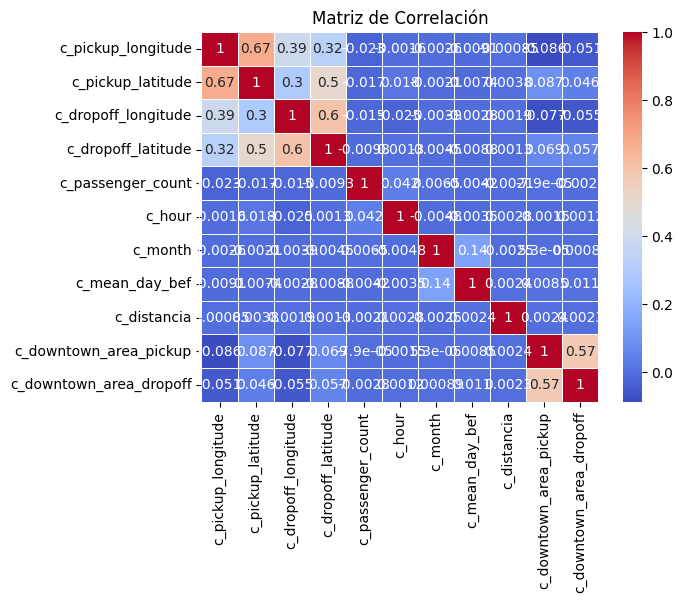

In [252]:
corr = X_test.drop('c_fare_amount', axis=1).corr(method="spearman")

sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)

# Agregar título
plt.title('Matriz de Correlación')

# Mostrar la figura
plt.show()

In [253]:
corr=abs(corr)

In [254]:
for col in corr.columns:
    display(corr[[col]][corr[[col]]>.8].dropna())

,c_pickup_longitude
c_pickup_longitude,1.0


,c_pickup_latitude
c_pickup_latitude,1.0


,c_dropoff_longitude
c_dropoff_longitude,1.0


,c_dropoff_latitude
c_dropoff_latitude,1.0


,c_passenger_count
c_passenger_count,1.0


,c_hour
c_hour,1.0


,c_month
c_month,1.0


,c_mean_day_bef
c_mean_day_bef,1.0


,c_distancia
c_distancia,1.0


,c_downtown_area_pickup
c_downtown_area_pickup,1.0


,c_downtown_area_dropoff
c_downtown_area_dropoff,1.0


no detectamemos variables con correlacion arriba de o.8

## Correlación con el objetivo

In [255]:
corr=X_train.corr(method="spearman")
corr=abs(corr)

In [256]:
corr[["c_fare_amount"]].sort_values(by = 'c_fare_amount',ascending = False).style.background_gradient()

,c_fare_amount
c_fare_amount,1.000000
c_distancia,0.845854
c_mean_day_bef,0.135808
c_dropoff_latitude,0.073639
c_dropoff_longitude,0.070327
c_pickup_latitude,0.065301
c_downtown_area_pickup,0.039048
c_month,0.024998
c_pickup_longitude,0.021365
c_passenger_count,0.019325


vamos a eliminar aquellas variables que tengan correlación por debajo de 0.02

In [257]:
corr=corr[["c_fare_amount"]].sort_values(by = 'c_fare_amount',ascending = False)

In [258]:
cols_drop_low_corr = list(corr[corr["c_fare_amount"]<.02].index)
cols_drop_low_corr

['c_passenger_count', 'c_downtown_area_dropoff', 'c_hour']

se eliminarán el numero de pasajeras, si el area destino esta fuera de un radio de 0.2 del area central, y la hora del viaje

In [259]:
X_train=X_train.drop(columns=cols_drop_low_corr)
X_test=X_test.drop(columns=cols_drop_low_corr)

## Multicolinealidad

### Continuas

In [260]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [261]:
vif=calc_vif(X_train[[x for x in X_train.filter(like="c_") if x not in [ "c_fare_amount"]]])

In [262]:
vif

,variables,VIF
0,c_pickup_longitude,30491.516325
1,c_pickup_latitude,2767.233207
2,c_dropoff_longitude,28845.712041
3,c_dropoff_latitude,1839.708745
4,c_month,3.417740
5,c_mean_day_bef,7.149314
6,c_distancia,1.701589
7,c_downtown_area_pickup,313.924369


In [263]:
vif[vif["VIF"]>10].sort_values(by=["variables","VIF"],ascending=False).head(50)

,variables,VIF
0,c_pickup_longitude,30491.516325
1,c_pickup_latitude,2767.233207
2,c_dropoff_longitude,28845.712041
3,c_dropoff_latitude,1839.708745
7,c_downtown_area_pickup,313.924369


Eliminamos el VIF más alto y volvemos a ejecutar

In [267]:
X_train.drop(columns=["c_pickup_longitude"],inplace=True)
X_test.drop(columns=["c_pickup_longitude"],inplace=True)

In [268]:
vif=calc_vif(X_train[[x for x in X_train.filter(like="c_") if x not in [ "c_fare_amount"]]])
vif

,variables,VIF
0,c_pickup_latitude,2224.169529
1,c_dropoff_longitude,2121.908805
2,c_dropoff_latitude,1805.585656
3,c_month,3.417733
4,c_mean_day_bef,7.149273
5,c_distancia,1.644727
6,c_downtown_area_pickup,272.030963


In [269]:
vif[vif["VIF"]>10].sort_values(by=["variables","VIF"],ascending=False).head(50)

,variables,VIF
0,c_pickup_latitude,2224.169529
1,c_dropoff_longitude,2121.908805
2,c_dropoff_latitude,1805.585656
6,c_downtown_area_pickup,272.030963


In [270]:
X_train.drop(columns=["c_pickup_latitude"],inplace=True)
X_test.drop(columns=["c_pickup_latitude"],inplace=True)

In [271]:
vif=calc_vif(X_train[[x for x in X_train.filter(like="c_") if x not in [ "c_fare_amount"]]])
vif

,variables,VIF
0,c_dropoff_longitude,1525.313372
1,c_dropoff_latitude,1419.134369
2,c_month,3.417682
3,c_mean_day_bef,7.148580
4,c_distancia,1.644361
5,c_downtown_area_pickup,262.379912


In [272]:
X_train.drop(columns=["c_dropoff_longitude"],inplace=True)
X_test.drop(columns=["c_dropoff_longitude"],inplace=True)

In [273]:
vif=calc_vif(X_train[[x for x in X_train.filter(like="c_") if x not in [ "c_fare_amount"]]])
vif

,variables,VIF
0,c_dropoff_latitude,250.157109
1,c_month,3.415137
2,c_mean_day_bef,7.126901
3,c_distancia,1.636281
4,c_downtown_area_pickup,240.968550


In [274]:
X_train.drop(columns=["c_dropoff_latitude"],inplace=True)
X_test.drop(columns=["c_dropoff_latitude"],inplace=True)

In [275]:
vif=calc_vif(X_train[[x for x in X_train.filter(like="c_") if x not in [ "c_fare_amount"]]])
vif

,variables,VIF
0,c_month,3.399293
1,c_mean_day_bef,7.031731
2,c_distancia,1.571907
3,c_downtown_area_pickup,8.730639


Al final nos quedamos con 4 variables
* c_month
* c_mean_day_bef
* c_distancia
* c_downtown_area_pickup



# Datos Finales

In [276]:
X_train

,c_fare_amount,c_month,c_mean_day_bef,c_distancia,c_downtown_area_pickup
0,0.161556,0.090909,0.245980,0.001288,1.0
1,0.240686,0.000000,0.188903,0.002040,1.0
2,0.214309,0.545455,0.316936,0.001487,1.0
3,0.379163,0.090909,0.635529,0.003682,1.0
4,0.230795,0.636364,0.695821,0.001629,1.0
...,...,...,...,...,...
387298,0.878668,0.090909,0.347267,0.009430,1.0
387299,0.253874,0.090909,0.095333,0.003060,1.0
387300,0.346192,0.363636,0.387228,0.002762,1.0
387301,0.293439,0.272727,0.228535,0.003228,1.0


In [277]:
X_test

,c_fare_amount,c_month,c_mean_day_bef,c_distancia,c_downtown_area_pickup
0,0.395648,0.454545,0.578001,0.001288,1.0
1,0.379163,0.181818,0.654780,0.002040,1.0
2,0.187933,0.636364,0.271600,0.001487,1.0
3,0.362677,0.909091,0.645906,0.003682,1.0
4,0.131883,0.000000,0.538430,0.001629,1.0
...,...,...,...,...,...
165987,0.227498,0.363636,0.374562,0.000775,1.0
165988,0.148368,0.454545,0.300002,0.004262,1.0
165989,0.715463,0.363636,0.355992,0.011712,1.0
165990,0.187933,0.727273,0.321447,0.002981,1.0
